# 기본 세팅

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
interest = pd.read_csv('../data/interestRate.csv')
subway = pd.read_csv('../data/subwayInfo.csv')
park = pd.read_csv('../data/parkInfo.csv')
schools = pd.read_csv('../data/schoolinfo.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')
train_data = train_data.assign(_type = 'train').drop('index', axis=1)
test_data = test_data.assign(_type = 'test').drop('index', axis=1)
data = pd.concat([train_data, test_data], axis=0)

In [3]:
data['contract_year_month'] = data['contract_year_month'].apply(lambda x : datetime.strptime(str(x), '%Y%m'))

In [4]:
train_sample = train_data.sample(frac=0.01, random_state=42)
print(f"1/100 후 데이터셋 크기: {len(train_sample)}")
print(f"제거된 행의 수: {len(train_data) - len(train_sample)}")

1/100 후 데이터셋 크기: 18012
제거된 행의 수: 1783216


# train 데이터 파악

**floor(층수) 데이터 확인**

<Axes: xlabel='floor', ylabel='Count'>

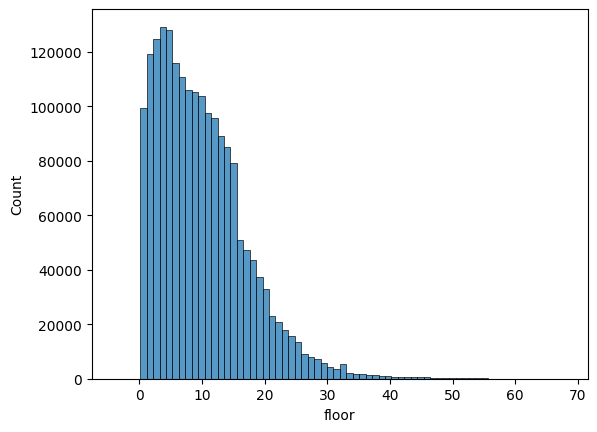

In [5]:
sns.histplot(data.floor, bins = 70)

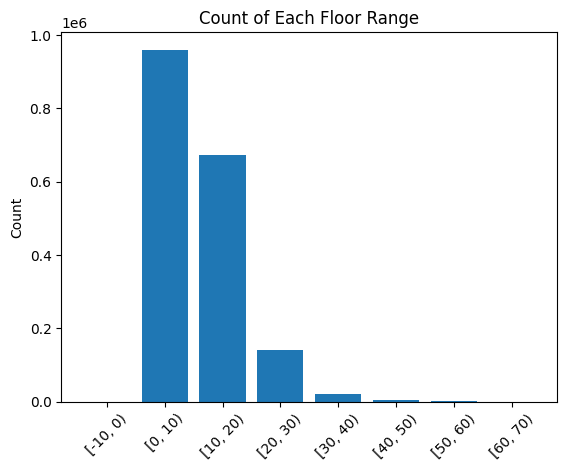

In [6]:
# 범주화
bins = range(-10, train_data['floor'].max() + 10, 10) 
train_data['floor_binned'] = pd.cut(train_data['floor'], bins=bins, right=False)

# 범주화된 데이터의 값 개수 계산
floor_binned_counts = train_data['floor_binned'].value_counts().sort_index()

# 막대 그래프 그리기
plt.bar(floor_binned_counts.index.astype(str), floor_binned_counts.values)
plt.ylabel('Count')
plt.title('Count of Each Floor Range')
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='floor', ylabel='deposit'>

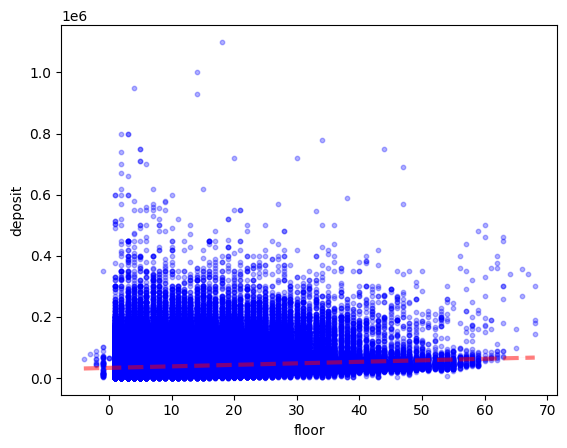

In [7]:
sns.regplot(x='floor', y = 'deposit', data = data, 
            scatter_kws={"fc":"b", "ec":"b", "s":10, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})

고층으로 갈수록 데이터는 적어지지만 전세가가 미약하지만 오르는 경향성을 보임

In [8]:
data['floor_cat'] = pd.cut(data['floor'], [-5,10,20,30,40,50,60,70])
data['area_m2_cat'] = pd.cut(data['area_m2'], [0,50,100,150,200,250,300,350])

In [9]:
data

area_m2 contract_year_month  contract_day  contract_type  floor  \
0        84.9981          2019-06-01            25              2      9   
1        84.9981          2020-03-01            26              2     20   
2        84.9981          2020-03-01            28              2      8   
3        59.3400          2019-07-01            15              2      1   
4        59.8100          2019-04-01            12              2      6   
...          ...                 ...           ...            ...    ...   
150167  115.5101          2024-02-01            27              0     17   
150168  142.8738          2024-03-01             2              0      4   
150169  142.8738          2024-03-01            16              1     13   
150170  114.9285          2024-03-01            22              1      2   
150171  115.5101          2024-03-01            22              1      7   

        built_year   latitude   longitude  age  deposit  _type floor_cat  \
0             2019  37.054314  127.045216    0  17000.0  train  (-5, 10]   
1             2019  37.054314  127.045216    1  23000.0  train  (10, 20]   
2             2019  37.054314  127.045216    1  23000.0  train  (-5, 10]   
3             1986  36.964647  127.055847   33   5000.0  train  (-5, 10]   
4             1995  36.972390  127.084514   24   1800.0  train  (-5, 10]   
...            ...        ...         ...  ...      ...    ...       ...   
150167        2010  37.528394  126.659398   14      NaN   test  (10, 20]   
150168        2010  37.528394  126.659398   14      NaN   test  (-5, 10]   
150169        2010  37.528394  126.659398   14      NaN   test  (10, 20]   
150170        2010  37.528394  126.659398   14      NaN   test  (-5, 10]   
150171        2010  37.528394  126.659398   14      NaN   test  (-5, 10]   

       area_m2_cat  
0        (50, 100]  
1        (50, 100]  
2        (50, 100]  
3        (50, 100]  
4        (50, 100]  
...            ...  
150167  (100, 150]  
150168  (100, 150]  
150169  (100, 150]  
150170  (100, 150]  
150171  (100, 150]  

[1951400 rows x 13 columns]

<Axes: xlabel='floor_cat', ylabel='deposit'>

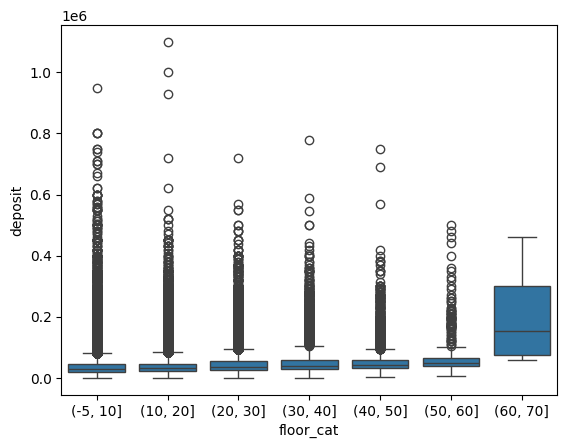

In [10]:
sns.boxplot(x=data['floor_cat'], y=data['deposit'])

60층 이상인 경우 가격이 높게 측정되는 경향성

**area_me(면적) 데이터 확인**

<Axes: xlabel='area_m2', ylabel='Count'>

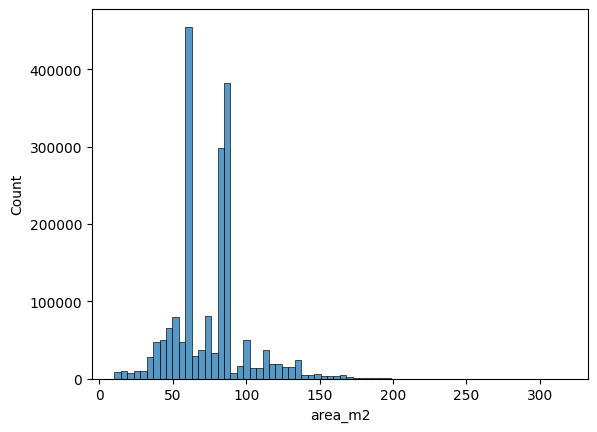

In [11]:
sns.histplot(data.area_m2, bins = 70)

18평,25평이 가장 많으며 작은 평수가 인기가 많음

<Axes: xlabel='area_m2', ylabel='deposit'>

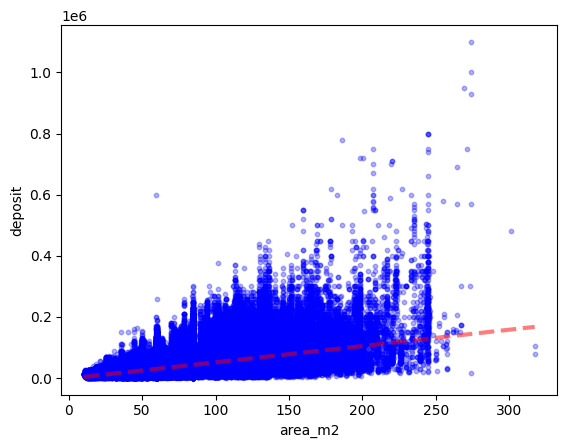

In [12]:
sns.regplot(x='area_m2', y = 'deposit', data = data, 
            scatter_kws={"fc":"b", "ec":"b", "s":10, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})

층수와 마찬가지로 면적이 커질수록 전세가가 올라가지만 좀 더 가파름

<Axes: xlabel='area_m2_cat', ylabel='deposit'>

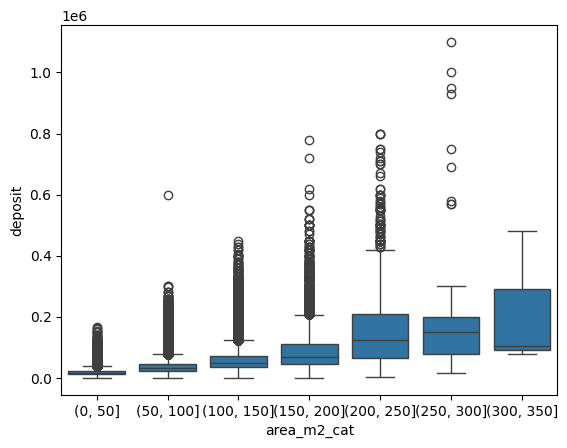

In [13]:
sns.boxplot(x=data['area_m2_cat'], y=data['deposit'])

면적이 커질수록 가격 변동이 커짐

면적 - 층수

/tmp/ipykernel_843423/4141959428.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = data.groupby(['floor_cat', 'area_m2_cat'])['deposit'].mean().reset_index()
/tmp/ipykernel_843423/4141959428.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = data.groupby(['floor_cat', 'area_m2_cat']).size().reset_index(name = 'count')


Text(158.22222222222223, 0.5, 'floor')

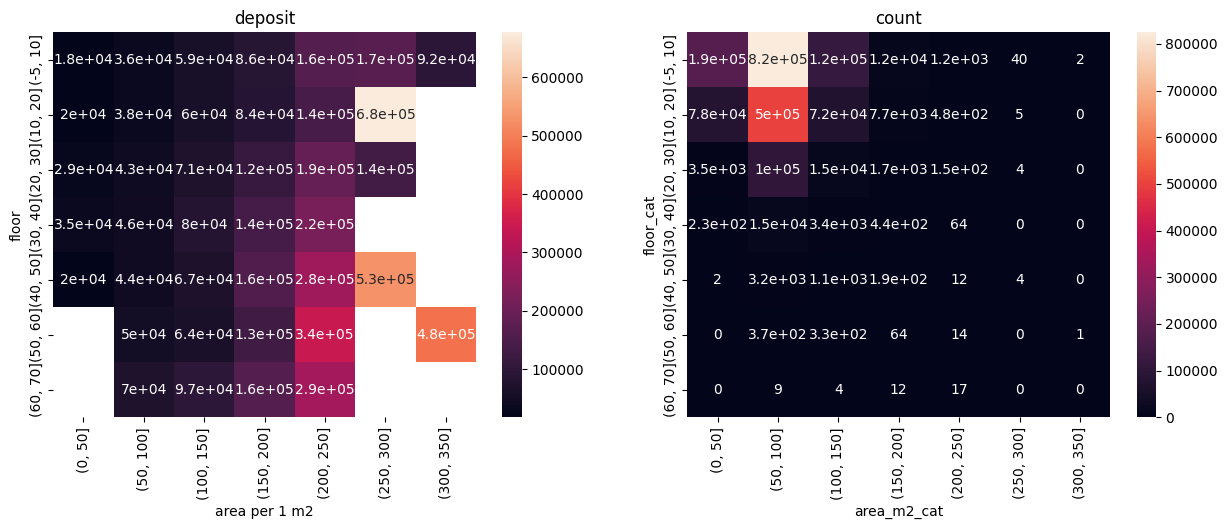

<Figure size 800x500 with 0 Axes>

In [14]:
temp = data.groupby(['floor_cat', 'area_m2_cat'])['deposit'].mean().reset_index()
temp2 = temp.pivot(index = 'floor_cat', columns = 'area_m2_cat', values = 'deposit')

fig, axes = plt.subplots(1,2, figsize = (15,5))
plt.figure(figsize = (8,5))
sns.heatmap(temp2, annot = True, ax = axes[0])
axes[0].set_title('deposit')
axes[0].set_xlabel('area per 1 m2')
axes[0].set_ylabel('floor')

temp = data.groupby(['floor_cat', 'area_m2_cat']).size().reset_index(name = 'count')
temp2 = temp.pivot(index = 'floor_cat', columns = 'area_m2_cat', values = 'count')

sns.heatmap(temp2, annot = True, ax = axes[1])
axes[1].set_title('count')
axes[0].set_xlabel('area per 1 m2')
axes[0].set_ylabel('floor')

- 층수가 높아질수록, 면적이 넓어질수록 전세가는 높아지는 경향
- 특이한 점은 250~300m2 면적 아파트는 특히나 가격대가 높고, 10-20층에서 가장 높음

In [15]:
data['date'] =  data['contract_year_month'].map(str) + data['contract_day'].map(str)
data['date'] = pd.to_datetime(data['date'])

# 이전까지의 계약 건수
data = data.sort_values(by='date')
data['contract_count'] = data.groupby(['longitude', 'latitude']).cumcount()

data['year'] = data['contract_year_month'].dt.year.astype(int)

/tmp/ipykernel_843423/2871030067.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])


Text(0, 0.5, 'deposit')

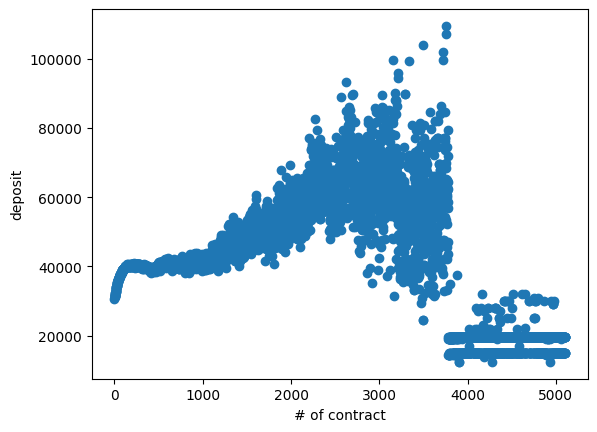

In [16]:
data['contract_count_cat'] = pd.cut(data['contract_count'], [0,1000,2000,3000,4000,5000])
temp = data.groupby('contract_count')['deposit'].mean().reset_index()
# temp['contract_count'] = np.log(temp['contract_count'])

plt.scatter(data = temp, x='contract_count', y = 'deposit')
plt.xlabel('# of contract')
plt.ylabel('deposit')

계약 건수별 전세가 중앙값 시각화
- 좀 이상한 패턴 존재..(?)
- 계약 건수가 3000 좀 넘어가면 살짝 떨어지다가 3000 후반부터는 훅 떨어짐

/tmp/ipykernel_843423/3287078474.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp2 = temp.groupby('contract_count_cat')['deposit'].mean().reset_index()
/tmp/ipykernel_843423/3287078474.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (temp.groupby('contract_count_cat')['year'].value_counts(normalize=True)


Text(0, 0.5, 'deposit')

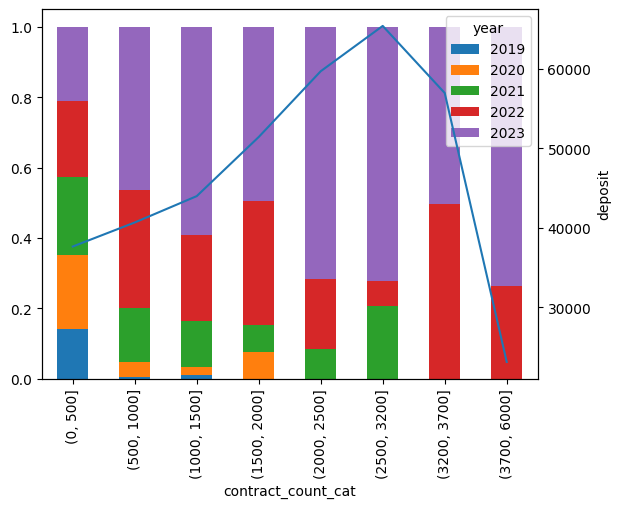

In [17]:
data['contract_count_cat'] = pd.cut(data['contract_count'], [0,500, 1000, 1500, 2000, 2500, 3200, 3700, 6000])
temp = data[data._type == 'train']
temp2 = temp.groupby('contract_count_cat')['deposit'].mean().reset_index()
temp2['contract_count_cat'] = temp2['contract_count_cat'].astype(str)

fig, ax1 = plt.subplots()
(temp.groupby('contract_count_cat')['year'].value_counts(normalize=True)
   .unstack('year').plot.bar(stacked=True, ax = ax1)
)

ax2 = ax1.twinx()
ax2.plot('contract_count_cat', 'deposit', data = temp2)
plt.xlabel('# of contract')
plt.ylabel('deposit')

계약 건수 범주화해서 시각화
- 선 : 전세가 평균, 막대 : 년도별 비중
- 3200건 이후부터 전세가가 훅훅 떨어지는데 이때 2022와 2023년 비중이 커짐

In [18]:
# 날짜 컬럼 생성
data['contract_date'] = pd.to_datetime(data['contract_year_month'].astype(str) + data['contract_day'].astype(str).str.zfill(2), format='%Y%m%d')

# 날짜별 거래량 확인
fig = plt.figure(figsize=(12, 6))
df = data[data['contract_type'] == 0]  
sns.histplot(df['contract_date'], bins=100)
plt.title('Daily Transaction Volume')
plt.xlabel('Contract Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ValueError: time data "2019-04-0101" doesn't match format "%Y%m%d", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

# deposit과 거래량 추세 확인

/tmp/ipykernel_843423/3953625911.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(avg_deposit_by_month.index, rotation=45)


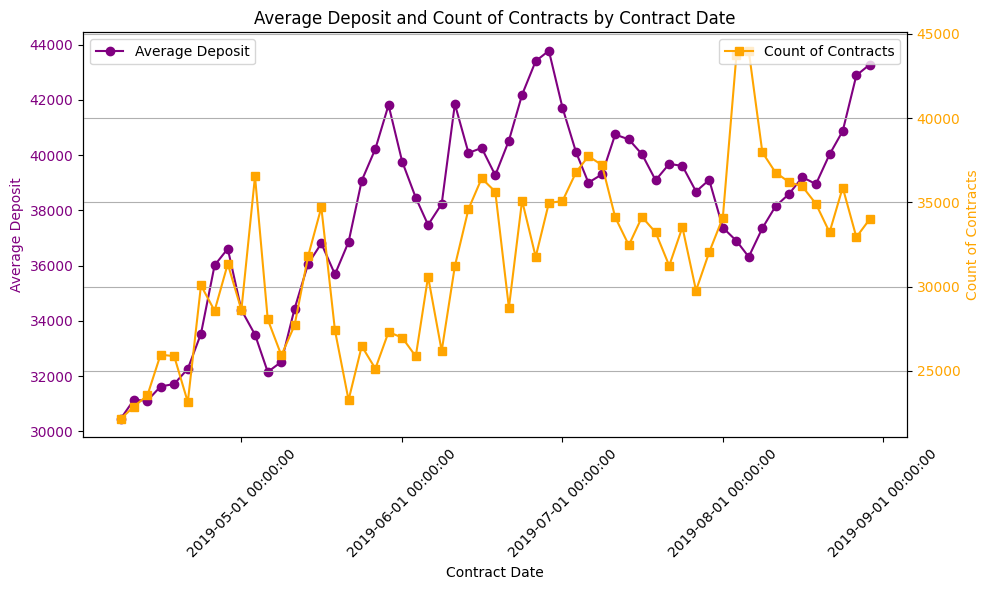

In [41]:
train_data['contract_date'] = pd.to_datetime(train_data['contract_year_month'], format='%Y%m')

# 연도와 월 변수 생성
train_data['contract_year'] = train_data['contract_date'].dt.year
train_data['contract_month'] = train_data['contract_date'].dt.month

fig, ax1 = plt.subplots(figsize=(10, 6))
# Deposit 추세
avg_deposit_by_month = train_data.groupby('contract_date')['deposit'].mean()

# 거래량 추세
count_contracts_by_month = train_data.groupby('contract_date')['contract_date'].count()

# 첫 번째 Y축: deposit 평균
ax1.plot(avg_deposit_by_month.index, avg_deposit_by_month.values, marker='o', linestyle='-', color='purple', label='Average Deposit')
ax1.set_xlabel('Contract Date')
ax1.set_ylabel('Average Deposit', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')
ax1.set_xticklabels(avg_deposit_by_month.index, rotation=45)

# 두 번째 Y축: contract_date 개수
ax2 = ax1.twinx() 
ax2.plot(count_contracts_by_month.index, count_contracts_by_month.values, marker='s', linestyle='-', color='orange', label='Count of Contracts')
ax2.set_ylabel('Count of Contracts', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Average Deposit and Count of Contracts by Contract Date')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

Correlation between Average Deposit and Count of Contracts: 0.47


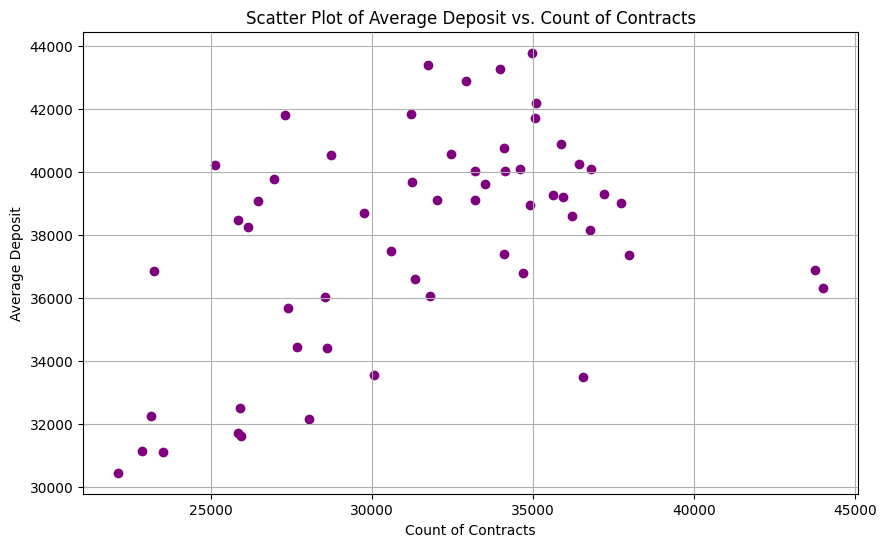

In [42]:
correlation_data = pd.DataFrame({
    'Average_Deposit': avg_deposit_by_month,
    'Count_Contracts': count_contracts_by_month
}).dropna() 


correlation = correlation_data.corr().iloc[0, 1]
print(f'Correlation between Average Deposit and Count of Contracts: {correlation:.2f}')

plt.figure(figsize=(10, 6))
plt.scatter(correlation_data['Count_Contracts'], correlation_data['Average_Deposit'], color='purple')
plt.title('Scatter Plot of Average Deposit vs. Count of Contracts')
plt.xlabel('Count of Contracts')
plt.ylabel('Average Deposit')
plt.grid(True)
plt.show()

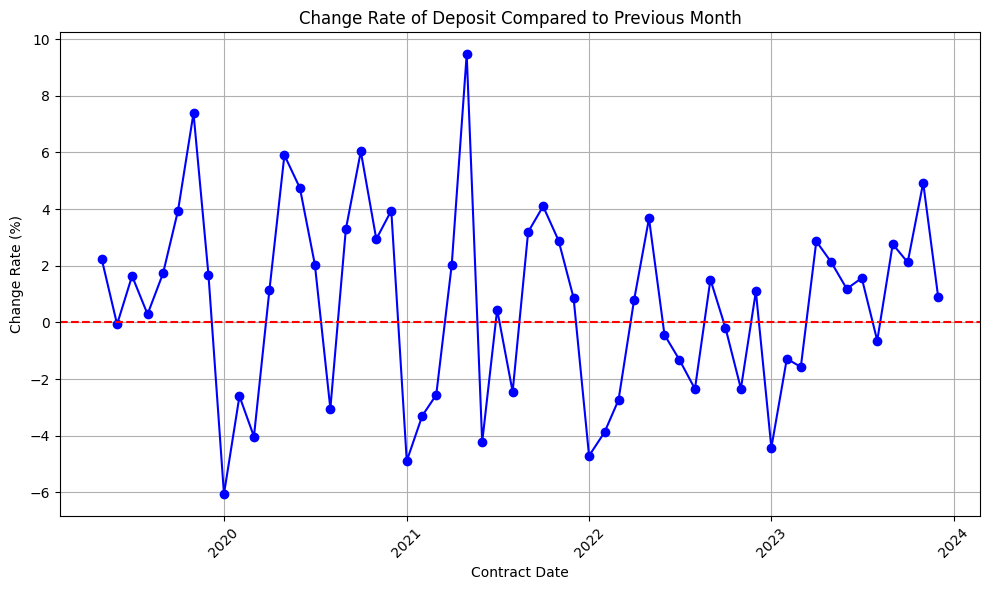

In [73]:
# deposit 변화율
deposit_change_rate = avg_deposit_by_month.pct_change() * 100 

plt.figure(figsize=(10, 6))
plt.plot(deposit_change_rate.index, deposit_change_rate, marker='o', linestyle='-', color='blue')
plt.title('Change Rate of Deposit Compared to Previous Month')
plt.xlabel('Contract Date')
plt.ylabel('Change Rate (%)')
plt.xticks(rotation=45)  # x축 라벨 각도 조정
plt.axhline(0, color='red', linestyle='--')  # 0% 변화선
plt.grid(True)
plt.tight_layout()
plt.show()

# train 데이터 자세히 살펴보기

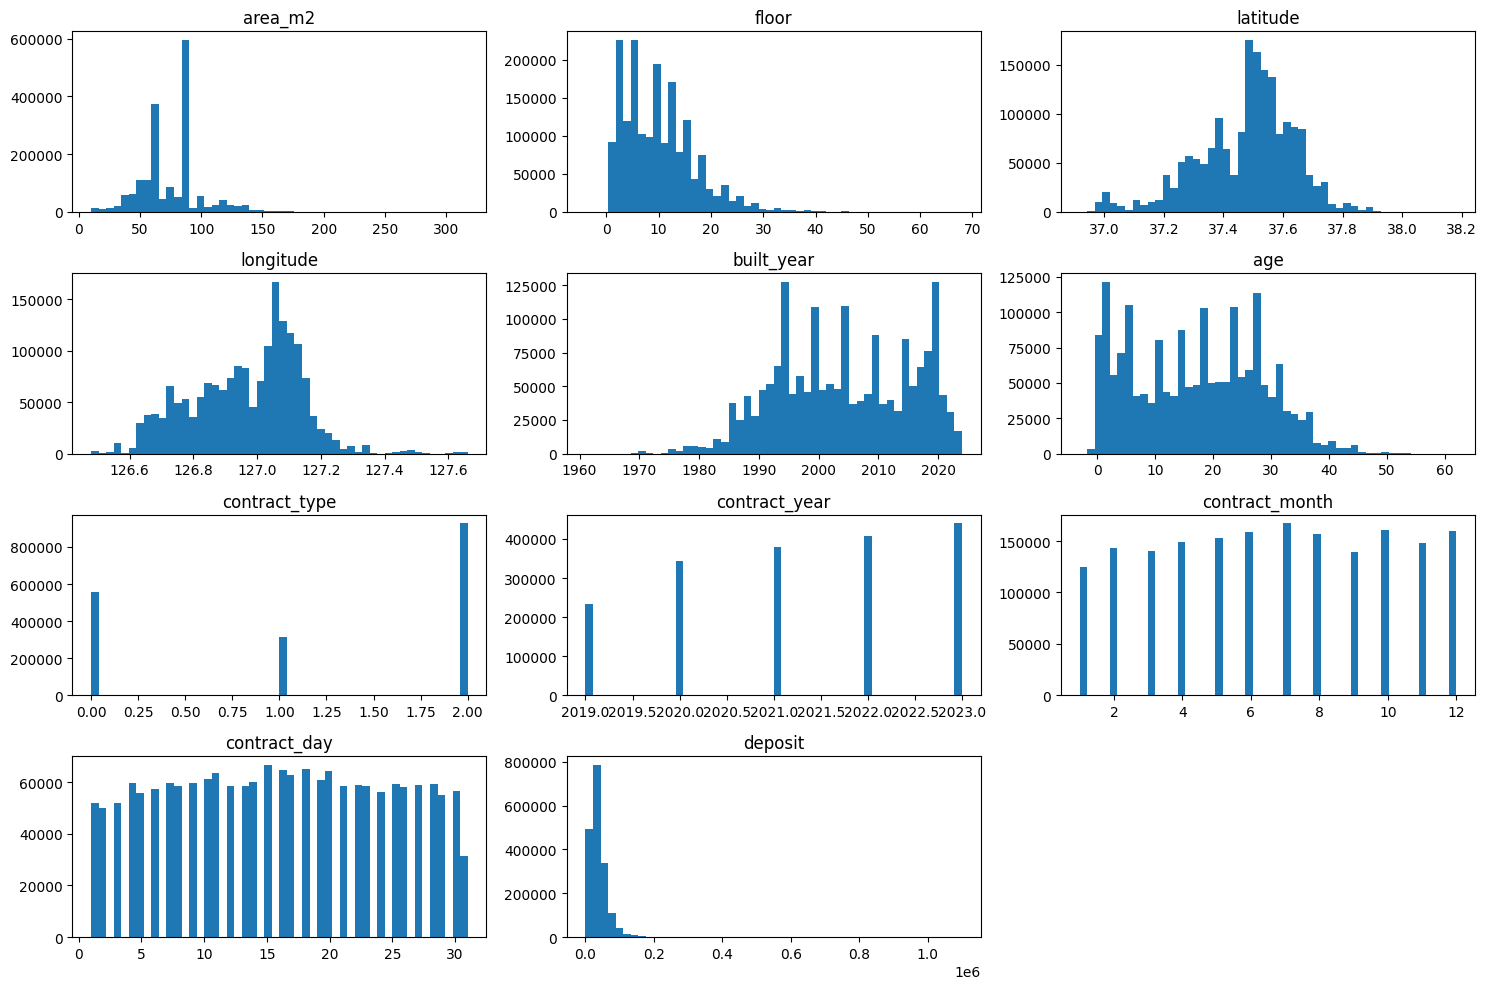

In [74]:
train_data[['area_m2', 'floor', 'latitude', 'longitude','built_year', 'age', 'contract_type', 'contract_year', 'contract_month', 'contract_day','deposit' ]].hist(figsize=(15, 10), bins=50, grid=False)

plt.tight_layout()
plt.show()

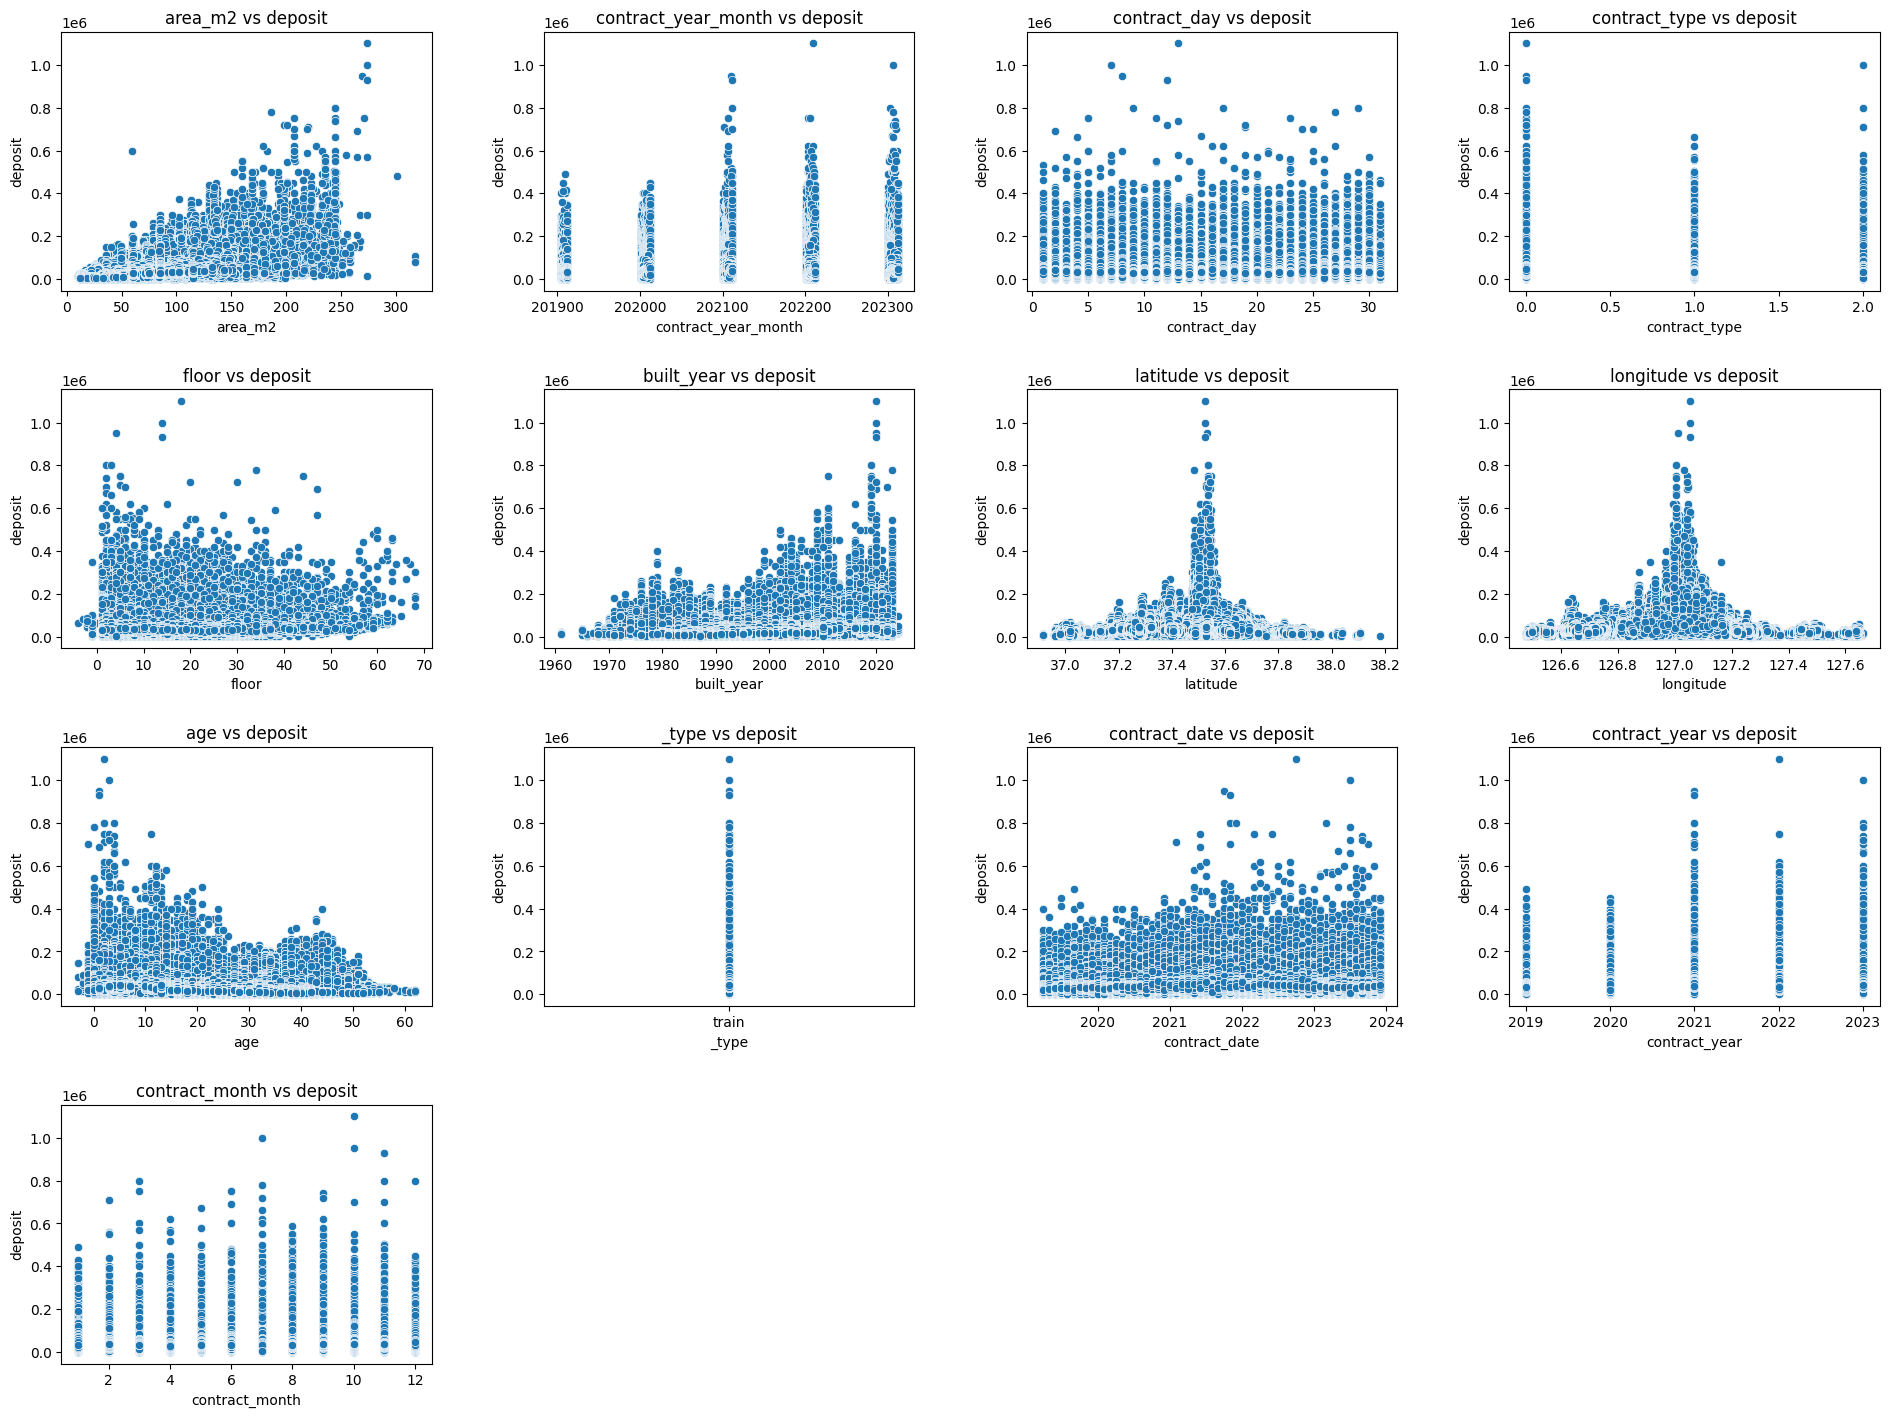

In [76]:
def plot_scatter_4x4(train):
    # 'deposit'을 제외한 나머지 열 선택
    columns = [col for col in train.columns if col != 'deposit']
    
    # 필요한 서브플롯 수 계산
    n_cols = 4
    n_rows = int(np.ceil(len(columns) / n_cols))
    
    # 그래프 그리기
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
    fig.tight_layout(pad=5.0)
    
    y = train['deposit']  # y축으로 사용할 'deposit'
    
    for i, col in enumerate(columns):
        row = i // n_cols
        col_pos = i % n_cols
        sns.scatterplot(x=train[col], y=y, ax=axes[row, col_pos])
        axes[row, col_pos].set_title(f'{col} vs deposit')
        axes[row, col_pos].set_xlabel(col)
        axes[row, col_pos].set_ylabel('deposit')
    
    # 남은 빈 그래프 제거
    for i in range(len(columns), n_rows * n_cols):
        fig.delaxes(axes.flatten()[i])
    
    plt.show()

# 함수 실행
plot_scatter_4x4(train_data)

# Age(나이) 데이터 확인

<Axes: xlabel='age', ylabel='deposit'>

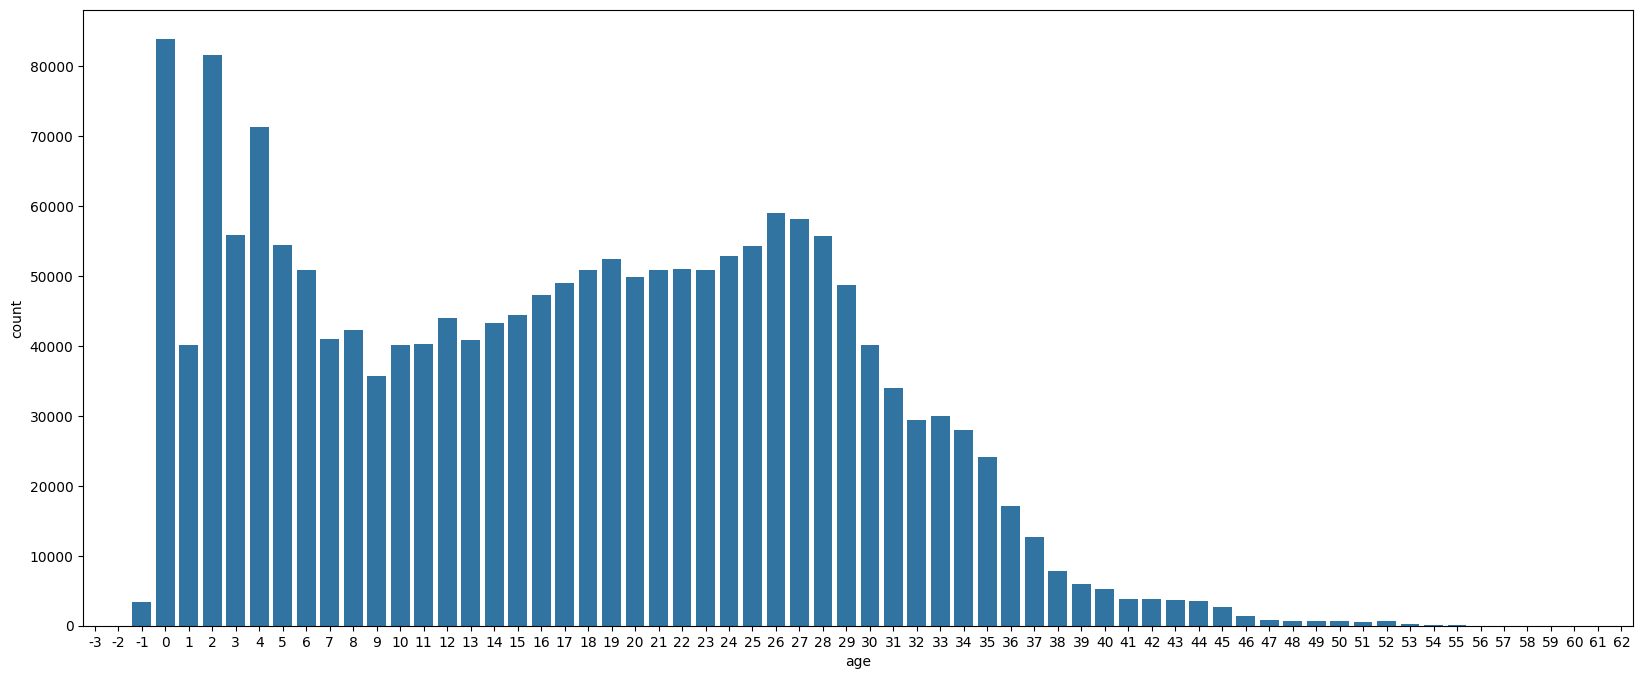

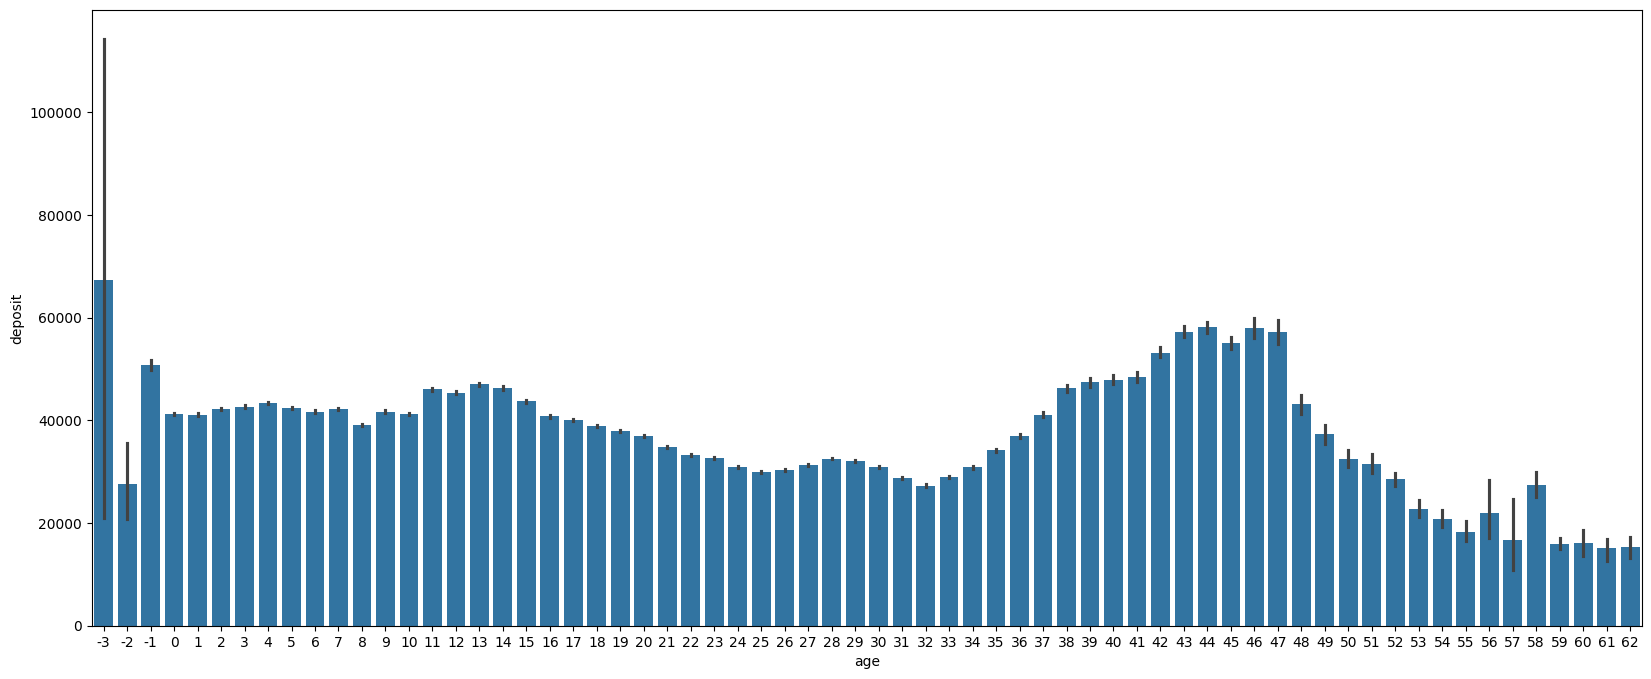

In [66]:
# 나이별 거래량
plt.figure(figsize=(20, 8))
sns.countplot(data=train_data, x='age')

# 나이별 deposit
plt.figure(figsize=(20, 8))
sns.barplot(data=train_data, x='age', y='deposit')

하락하는 추세를 보이다가, 30년 지점에서 다시 상승

# 위도, 경도 데이터 활용

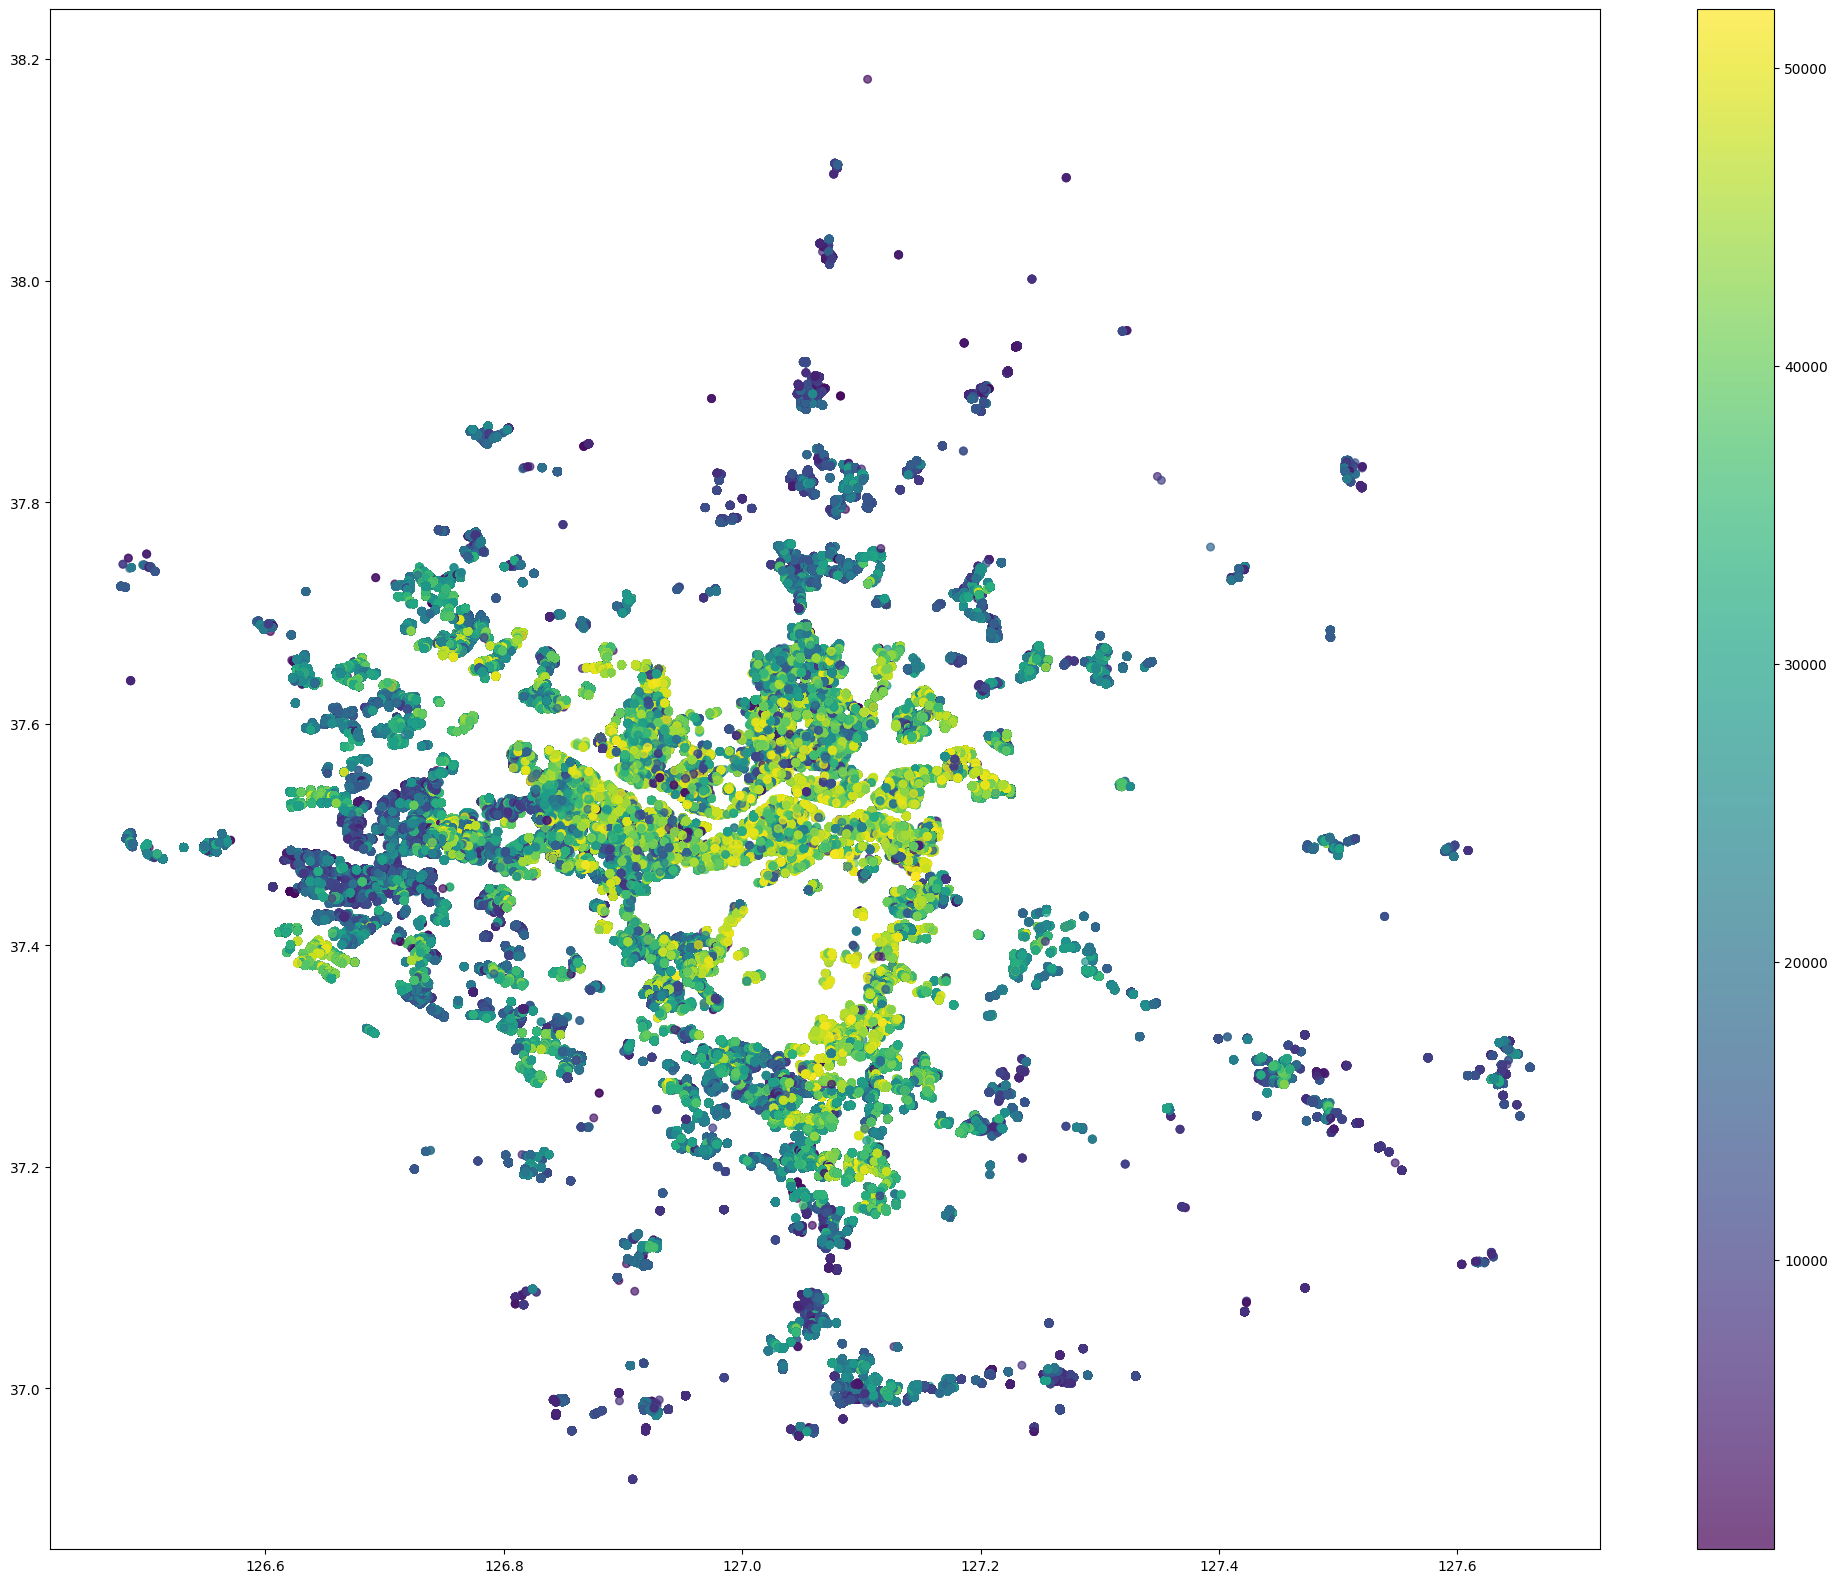

In [65]:
# deposit이 80% 미만인 데이터만 표시
plot_df = train_data[train_data['deposit'] < train_data['deposit'].quantile(0.8)]

plt.figure(figsize=(25, 20))

plt.scatter(plot_df['longitude'], plot_df['latitude'], c=plot_df['deposit'], cmap='viridis', s=30, alpha=0.7)
plt.colorbar()
plt.show()

# train과 interest 합치기

In [20]:
# contract_year_month를 문자열로 변환
train_data['contract_year_month'] = train_data['contract_year_month'].astype(str)

# interest 데이터프레임의 year_month를 문자열로 변환
interest['year_month'] = interest['year_month'].astype(str)

# 병합 수행
train2 = train_data.merge(interest[['year_month', 'interest_rate']], 
                          left_on='contract_year_month', 
                          right_on='year_month', 
                          how='left')

# 불필요한 컬럼 제거
train2.drop(columns=['year_month'], inplace=True)

print(train2.head())

   area_m2 contract_year_month  contract_day  contract_type  floor  \
0  84.9981              201906            25              2      9   
1  84.9981              202003            26              2     20   
2  84.9981              202003            28              2      8   
3  59.3400              201907            15              2      1   
4  59.8100              201904            12              2      6   

   built_year   latitude   longitude  age  deposit  _type floor_binned  \
0        2019  37.054314  127.045216    0  17000.0  train      [0, 10)   
1        2019  37.054314  127.045216    1  23000.0  train     [20, 30)   
2        2019  37.054314  127.045216    1  23000.0  train      [0, 10)   
3        1986  36.964647  127.055847   33   5000.0  train      [0, 10)   
4        1995  36.972390  127.084514   24   1800.0  train      [0, 10)   

   interest_rate  
0           1.78  
1           1.26  
2           1.26  
3           1.68  
4           1.85  


In [21]:
# ['latitude', 'longitude']별로 그룹화
df = train2.groupby(['latitude', 'longitude']).agg(
    count=('latitude', 'size'),  # 거래 횟수
    avg_deposit=('deposit', 'mean')  # 평균 deposit 계산
).reset_index()

df_sorted = df.sort_values(by='avg_deposit', ascending=False)

pd.set_option('display.max_rows', None)

pd.reset_option('display.max_rows')

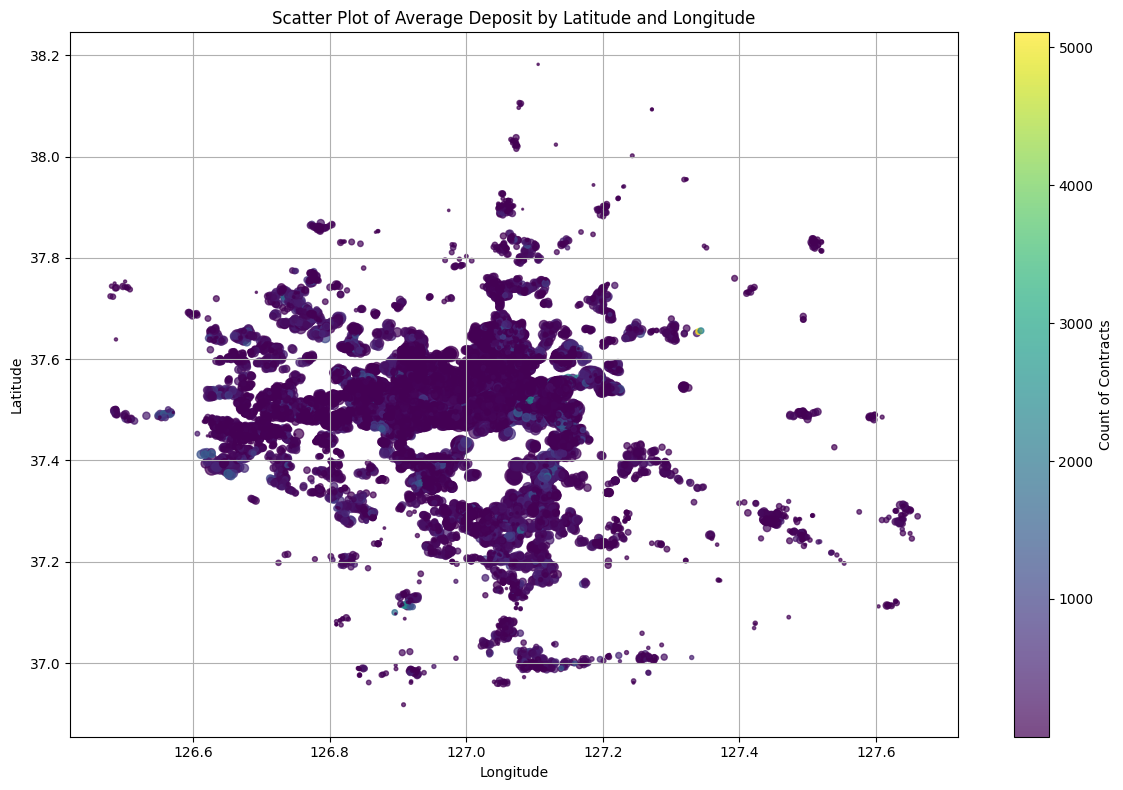

In [91]:
# 산점도 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df_sorted['longitude'], 
    df_sorted['latitude'], 
    s=df_sorted['avg_deposit'] / 1000,  # avg_deposit에 따라 점 크기 조정
    c=df_sorted['count'],  # 거래 횟수에 따라 색상 조정
    cmap='viridis',  # 색상 맵
    alpha=0.7  # 투명도 조정
)

# 색상바 추가
cbar = plt.colorbar(scatter)
cbar.set_label('Count of Contracts')  # 색상바 레이블

# 그래프 제목 및 축 레이블 설정
plt.title('Scatter Plot of Average Deposit by Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.grid(True)
plt.tight_layout()
plt.show()


# 학교, 공원 범위 제한

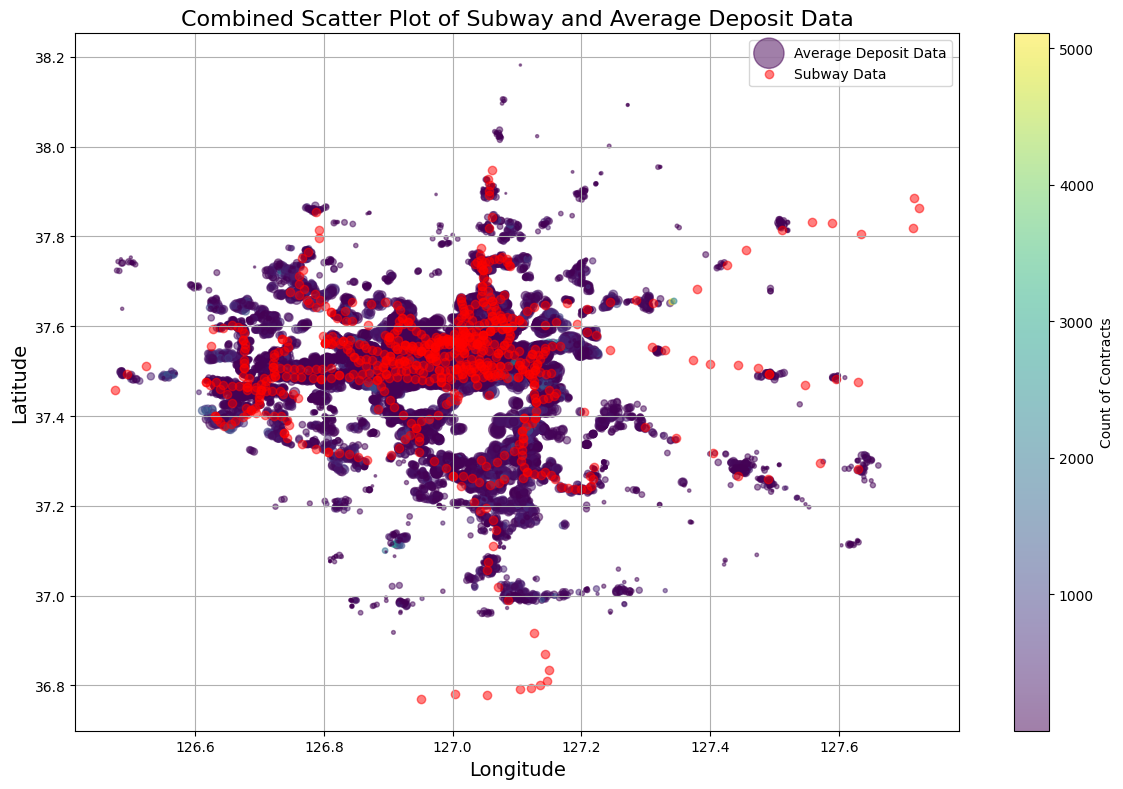

In [92]:
# 산점도 시각화
plt.figure(figsize=(12, 8))

# df_sorted 데이터에 대한 산점도
scatter2 = plt.scatter(
    df_sorted['longitude'], 
    df_sorted['latitude'], 
    s=df_sorted['avg_deposit'] / 1000,  # avg_deposit에 따라 점 크기 조정
    c=df_sorted['count'],  # 거래 횟수에 따라 색상 조정
    cmap='viridis',  
    alpha=0.5, 
    label='Average Deposit Data'  # 범례에 표시할 라벨
)

# subway 데이터에 대한 산점도
scatter1 = plt.scatter(
    subway['longitude'], 
    subway['latitude'], 
    color='red',  
    alpha=0.5, 
    label='Subway Data'  
)

cbar = plt.colorbar(scatter2)
cbar.set_label('Count of Contracts')  

plt.title('Combined Scatter Plot of Subway and Average Deposit Data', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

plt.legend(loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

# 지하철 데이터 파악

- 가장 가까운 지하철 역까지의 거리 변수
- ?km 반경 내의 지하철 개수
- 지하철 기준으로 지역 그룹화

In [28]:
subway = subway.drop_duplicates()

In [27]:
from haversine import haversine, Unit

In [25]:
# KD-Tree를 사용해 가장 가까운 공간을 찾는 함수
def find_nearest_place(lat, lon, place_tree, place_coordinates):
    # 주어진 좌표에 대해 가장 가까운 공간 인덱스 찾기
    distance, index = place_tree.query([lat, lon], k=1)
    
    # 가장 가까운 지하철 역의 좌표
    nearest_place = place_coordinates[index]
    
    # Haversine 공식을 사용하여 거리 계산
    dist_km = haversine((lat, lon), (nearest_place[0], nearest_place[1]), unit=Unit.KILOMETERS)
    
    return dist_km, index, nearest_place[0], nearest_place[1]


# KD-Tree를 사용해 반경 안의 공간 개수를 찾는 함수
def count_within_radius(radius, lat, lon, place_tree):
    # 주어진 좌표에 대해 가장 가까운 공간 인덱스 찾기
    counts = place_tree.query_ball_point([lat, lon], r=radius, return_length = True)    
    return counts

In [29]:
apartment_loc = data[['latitude', 'longitude']].drop_duplicates()
subway_coordinates = subway[['latitude', 'longitude']].values
subway_tree = cKDTree(subway_coordinates)

apartment_loc['distance_to_subway'], apartment_loc['closest_subway'], apartment_loc['latitude_subway'], apartment_loc['longitude_subway'] = zip(*apartment_loc.apply(
    lambda row: find_nearest_place(row['latitude'], row['longitude'], subway_tree, subway_coordinates), axis=1))

In [30]:
km = 1
radius = km/111
apartment_loc['subway_count_1km'] = apartment_loc.apply(lambda row: count_within_radius(radius, row['latitude'], row['longitude'], subway_tree), axis=1)

In [31]:
data = data.merge(apartment_loc, how = 'left')

In [32]:
data['minute_subway'] = data['distance_to_subway']/4*60
data['minute_subway_cat'] = pd.cut(data['minute_subway'], [0,10,20,60,np.inf], labels =['~10','10~20','20~120','120~'])

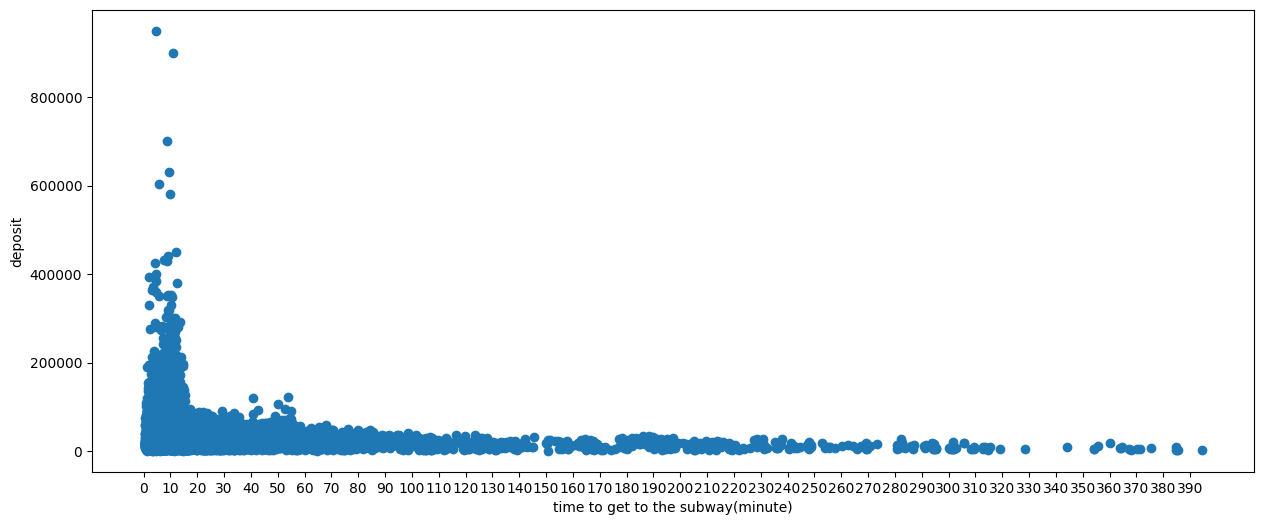

In [33]:
temp = data.groupby('minute_subway')['deposit'].mean().reset_index()
plt.figure(figsize=(15,6))
plt.scatter(x = 'minute_subway', y = 'deposit', data = temp)
plt.xlabel('time to get to the subway(minute)')
plt.ylabel('deposit')
plt.xticks(range(0,400,10))
plt.show()

20분 안쪽으로 역세권일 때 전세가가 높음

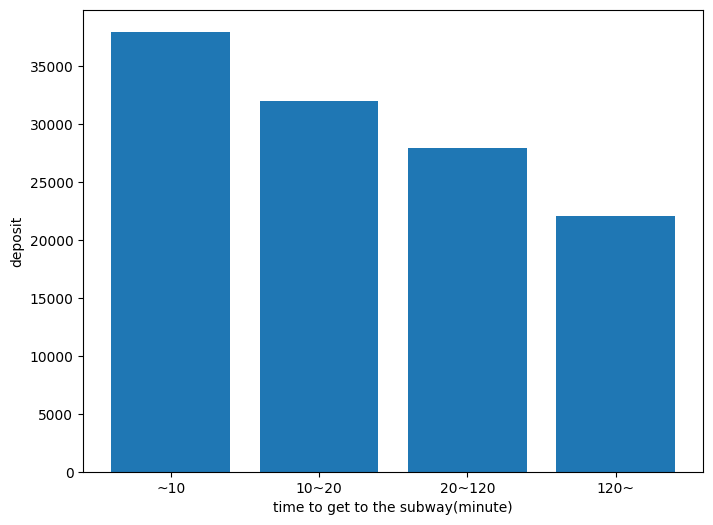

In [35]:
temp = data.groupby('minute_subway_cat')['deposit'].median().reset_index()
plt.figure(figsize=(8,6))
plt.bar(x='minute_subway_cat', height='deposit', data=temp)
plt.xlabel('time to get to the subway(minute)')
plt.ylabel('deposit')
plt.show()

역세권일수록 전세가가 높음

Text(0, 0.5, 'deposit')

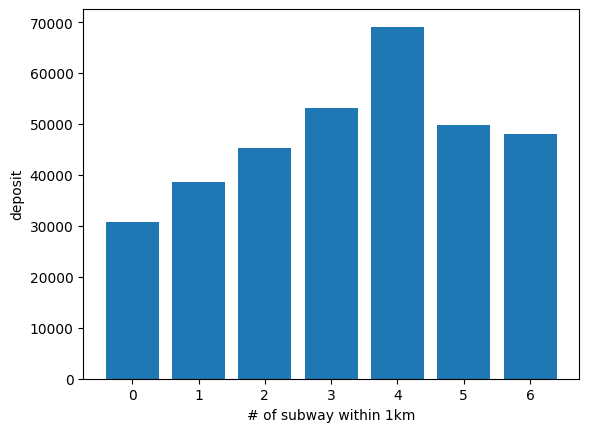

In [25]:
temp = data.groupby('subway_count_1km')['deposit'].mean().reset_index()
plt.bar(x='subway_count_1km', height ='deposit', data = temp)
plt.xlabel('# of subway within 1km')
plt.ylabel('deposit')

1km 반경 내 지하철 수
- 주변에 지하철 4개정도 까지는 전세가가 전반적으로 상승하는 편
- 5,6개 정도로 너무 많으면 오히려 떨어짐

In [26]:
temp = data.groupby(['closest_subway', 'longitude_subway', 'latitude_subway']).size().reset_index(name = 'count')
temp['count'] = temp['count']/50

temp2 = data.groupby(['closest_subway'])['deposit'].mean().reset_index()
temp = temp.merge(temp2, how= 'left')

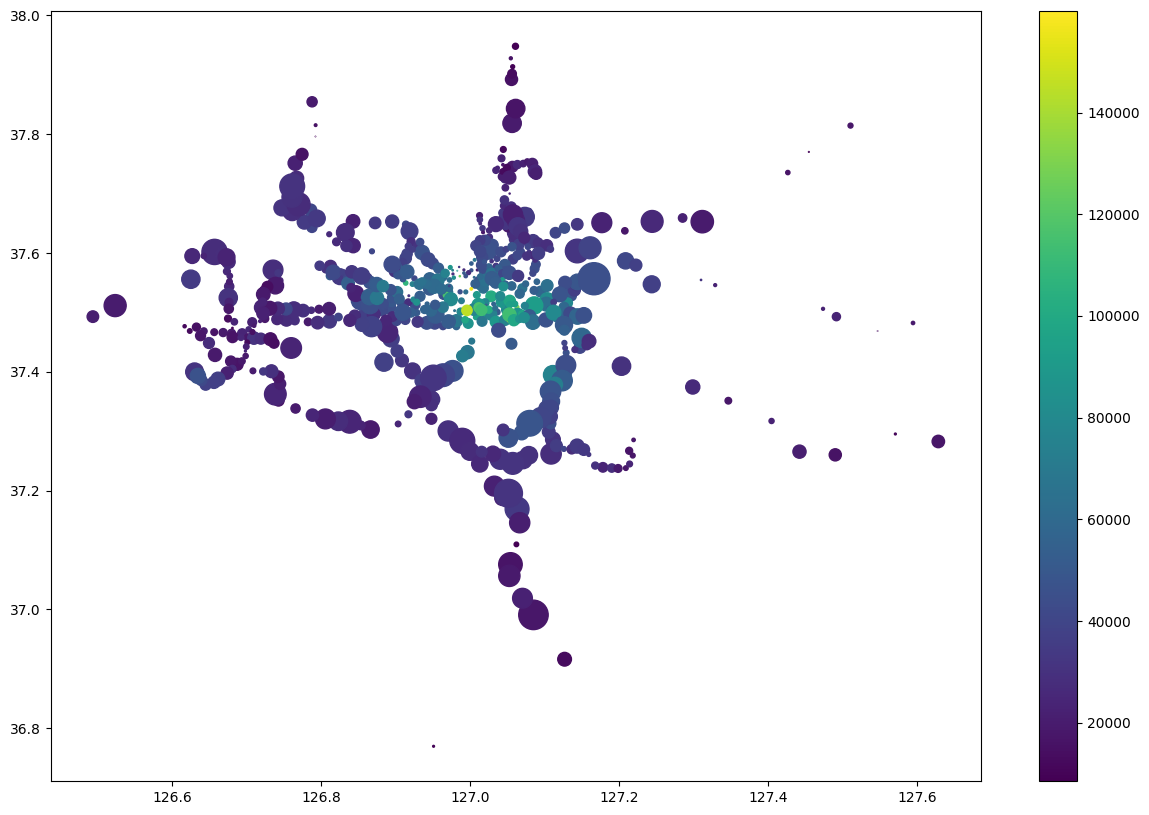

In [27]:
plt.figure(figsize=(15,10))
plt.scatter(x = 'longitude_subway', y = 'latitude_subway', c = 'deposit', s='count', data = temp)
plt.colorbar()

- 중심부의 전세가가 높고, 그룹에 속한 아파트 수가 적다
  - 지하철 역이 많아서 그런 듯
- 변두리로 갈수록 그룹이 커지고, 전세가가 낮아진다

집 근처 거리 반경 지하철 개수를 기준으로 상관관계 파악

   subway_count_1km  subway_count_3km  subway_count_5km  subway_count_10km  \
0                 1                 2                 3                  5   
1                 1                 2                 3                  5   
2                 1                 2                 3                  5   
3                 0                 0                 1                  3   
4                 0                 1                 1                  4   

   subway_count_15km  subway_count_20km  subway_count_25km  subway_count_30km  
0                  8                 11                 25                 50  
1                  8                 11                 25                 50  
2                  8                 11                 25                 50  
3                  6                 12                 18                 20  
4                  6                 11                 18                 20  


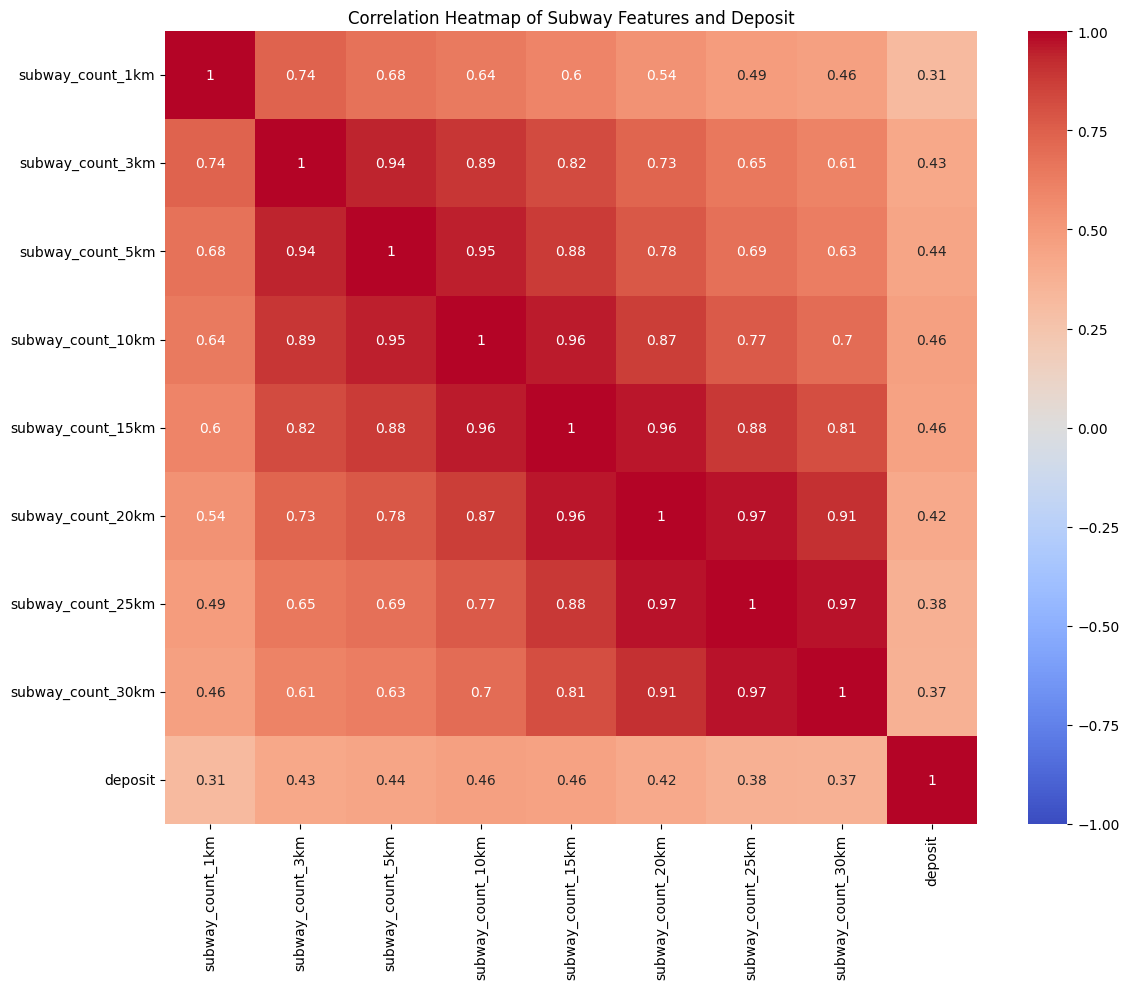

높은 상관관계를 가진 변수 쌍 (상관계수 > 0.8):
subway_count_3km - subway_count_5km: 0.9436
subway_count_3km - subway_count_10km: 0.8926
subway_count_3km - subway_count_15km: 0.8228
subway_count_5km - subway_count_10km: 0.9531
subway_count_5km - subway_count_15km: 0.8824
subway_count_10km - subway_count_15km: 0.9608
subway_count_10km - subway_count_20km: 0.8696
subway_count_15km - subway_count_20km: 0.9614
subway_count_15km - subway_count_25km: 0.8839
subway_count_15km - subway_count_30km: 0.8130
subway_count_20km - subway_count_25km: 0.9712
subway_count_20km - subway_count_30km: 0.9134
subway_count_25km - subway_count_30km: 0.9745

deposit과의 상관관계:
deposit              1.000000
subway_count_10km    0.463284
subway_count_15km    0.459709
subway_count_5km     0.440047
subway_count_3km     0.425609
subway_count_20km    0.420463
subway_count_25km    0.380744
subway_count_30km    0.374353
subway_count_1km     0.314987
Name: deposit, dtype: float64


In [28]:
def create_count_feature(df, poi_df, radius):
    poi_coords = poi_df[['latitude', 'longitude']].values
    poi_tree = BallTree(np.deg2rad(poi_coords), metric='haversine')
    
    apartment_coords = df[['latitude', 'longitude']].values
    
    count = poi_tree.query_radius(np.deg2rad(apartment_coords), r=radius/6371, count_only=True)
    return count

# 특성 추가 함수
def add_subway_features(df):
    df['subway_count_1km'] = create_count_feature(df, subway, 1)
    df['subway_count_3km'] = create_count_feature(df, subway, 3)
    df['subway_count_5km'] = create_count_feature(df, subway, 5)
    df['subway_count_10km'] = create_count_feature(df, subway, 10)
    df['subway_count_15km'] = create_count_feature(df, subway, 15)
    df['subway_count_20km'] = create_count_feature(df, subway, 20)
    df['subway_count_25km'] = create_count_feature(df, subway, 25)
    df['subway_count_30km'] = create_count_feature(df, subway, 30)
    return df

# 트레인과 테스트 데이터에 특성 추가
train_data = add_subway_features(train_data)
test_data = add_subway_features(test_data)

print(train_data[['subway_count_1km', 'subway_count_3km', 'subway_count_5km', 
                  'subway_count_10km', 'subway_count_15km', 'subway_count_20km',
                  'subway_count_25km', 'subway_count_30km']].head())

# 관심 있는 특성들의 리스트
features_of_interest = [
    'subway_count_1km', 'subway_count_3km', 'subway_count_5km', 
    'subway_count_10km', 'subway_count_15km', 'subway_count_20km',
    'subway_count_25km', 'subway_count_30km', 'deposit'
]

# 관심 있는 특성들만 선택
correlation_data = train_data[features_of_interest]

# 상관관계 계산
correlation_matrix = correlation_data.corr()

# 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation Heatmap of Subway Features and Deposit")
plt.tight_layout()
plt.show()

# 높은 상관관계를 가진 변수 쌍 찾기 (예: 0.8 이상)
high_correlation_pairs = []
for i in range(len(features_of_interest)):
    for j in range(i+1, len(features_of_interest)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_correlation_pairs.append((features_of_interest[i], features_of_interest[j], correlation_matrix.iloc[i, j]))

print("높은 상관관계를 가진 변수 쌍 (상관계수 > 0.8):")
for pair in high_correlation_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.4f}")

# deposit과의 상관관계 출력
print("\ndeposit과의 상관관계:")
deposit_correlations = correlation_matrix['deposit'].sort_values(ascending=False)
print(deposit_correlations)

# 공원 데이터 파악
개별 아파트 변수
- 가장 가까운 공원까지의 거리
- ?km 반경 공원 수, 면적 평균

집단 변수
- 지하철역 기준으로 매핑
- 지역 내 공원 수, 면적 평균

In [33]:
# 전국 데이터 -> 위도 경도 기준으로 데이터 잘라버리기
park = park[(park.longitude <= data.longitude.max()) & 
            (park.longitude >= data.longitude.min()) &
            (park.latitude <= data.latitude.max()) & 
            (park.latitude >= data.latitude.min())].reset_index(drop=True)

In [34]:
# 가장 가까운 공원까지의 거리, 면적
apartment_loc = data[['latitude', 'longitude']].drop_duplicates()
park_coordinates = park[['latitude', 'longitude']].values
park_tree = cKDTree(park_coordinates)

apartment_loc['distance_to_park'], apartment_loc['closest_park'], apartment_loc['latitude_park'], apartment_loc['longitude_park'] = zip(*apartment_loc.apply(
    lambda row: find_nearest_place(row['latitude'], row['longitude'], park_tree, park_coordinates), axis=1))

apartment_loc = apartment_loc.merge(park, left_on=['latitude_park', 'longitude_park'], right_on=['latitude', 'longitude'])
apartment_loc.rename(columns = {'latitude_x' : 'latitude', 'longitude_x' : 'longitude', 'area' : 'area_park'}, inplace = True)
apartment_loc = apartment_loc.drop(['latitude_y', 'longitude_y'], axis=1)

In [35]:
data = data.merge(apartment_loc, how = 'left')

Text(0, 0.5, 'deposit')

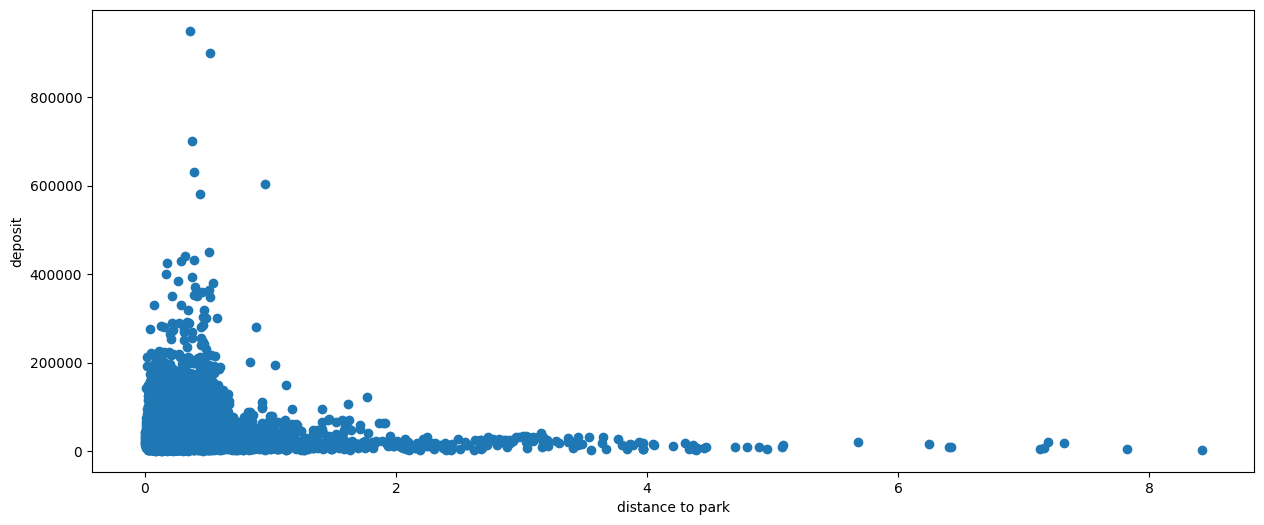

In [36]:
temp = data.groupby('distance_to_park')['deposit'].mean().reset_index()
plt.figure(figsize=(15,6))
plt.scatter(x = 'distance_to_park', y = 'deposit', data = temp)
plt.xlabel('distance to park')
plt.ylabel('deposit')

공원이 가까울수록 전셋값이 올라가는 경향

Text(0, 0.5, 'deposit')

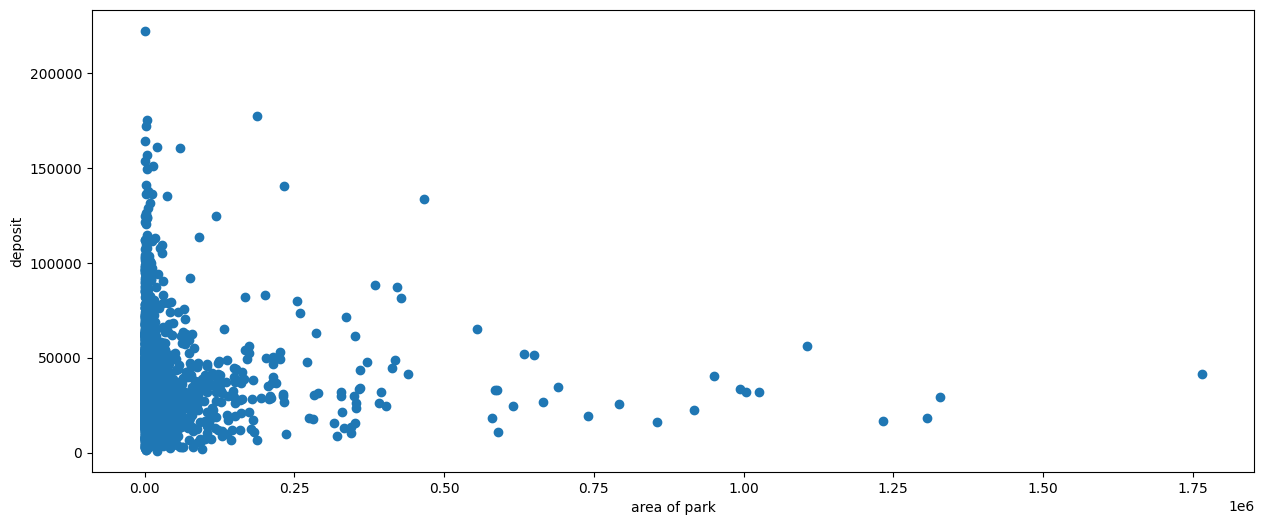

In [37]:
temp = data.groupby('area_park')['deposit'].mean().reset_index()
plt.figure(figsize=(15,6))
plt.scatter(x = 'area_park', y = 'deposit', data = temp)
plt.xlabel('area of park')
plt.ylabel('deposit')

가장 가까운 공원의 크기는 아무래도 작은 편 

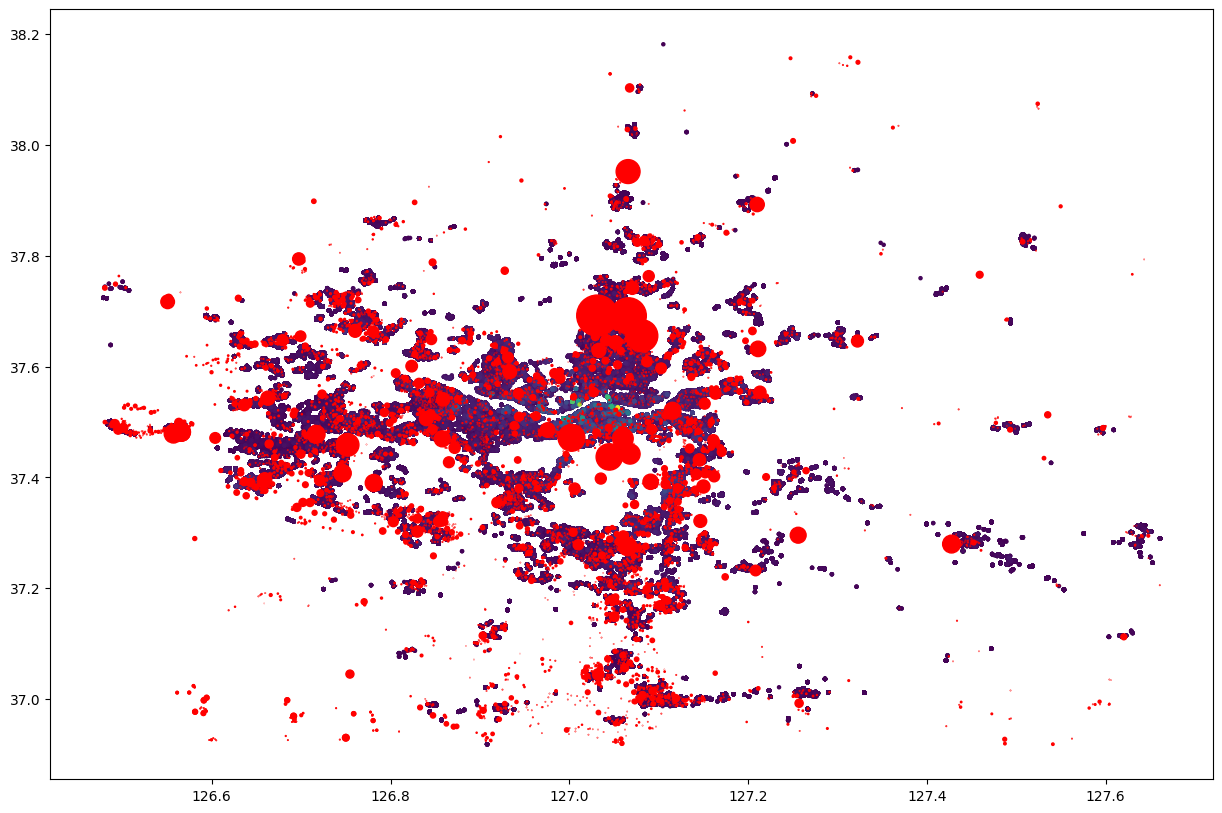

In [38]:
data = data.sort_values('deposit')
park['area2'] = park['area'] / 10000

plt.figure(figsize=(15,10))
plt.scatter(x = 'longitude', y = 'latitude', c = 'deposit', s=5, data = data)
plt.scatter(x = 'longitude', y = 'latitude', s = 'area2', color = 'red', data = park)

- 작은 공원이 그냥 전반적으로 많다. -> 서울쪽은 엄청 작은 공원들이 더 많은 것 같다?
- 일단 대공원은 확실히 변두리로 빠지는 듯

- 대공원(면적10만이상)
- 중공원(면적1만~10만)
- 소공원(면적 1만 이하)

크기로 분류해서 상관관계 분석 
- 전셋집 반경 개수
- 전셋집 반경 총 공원의 면적

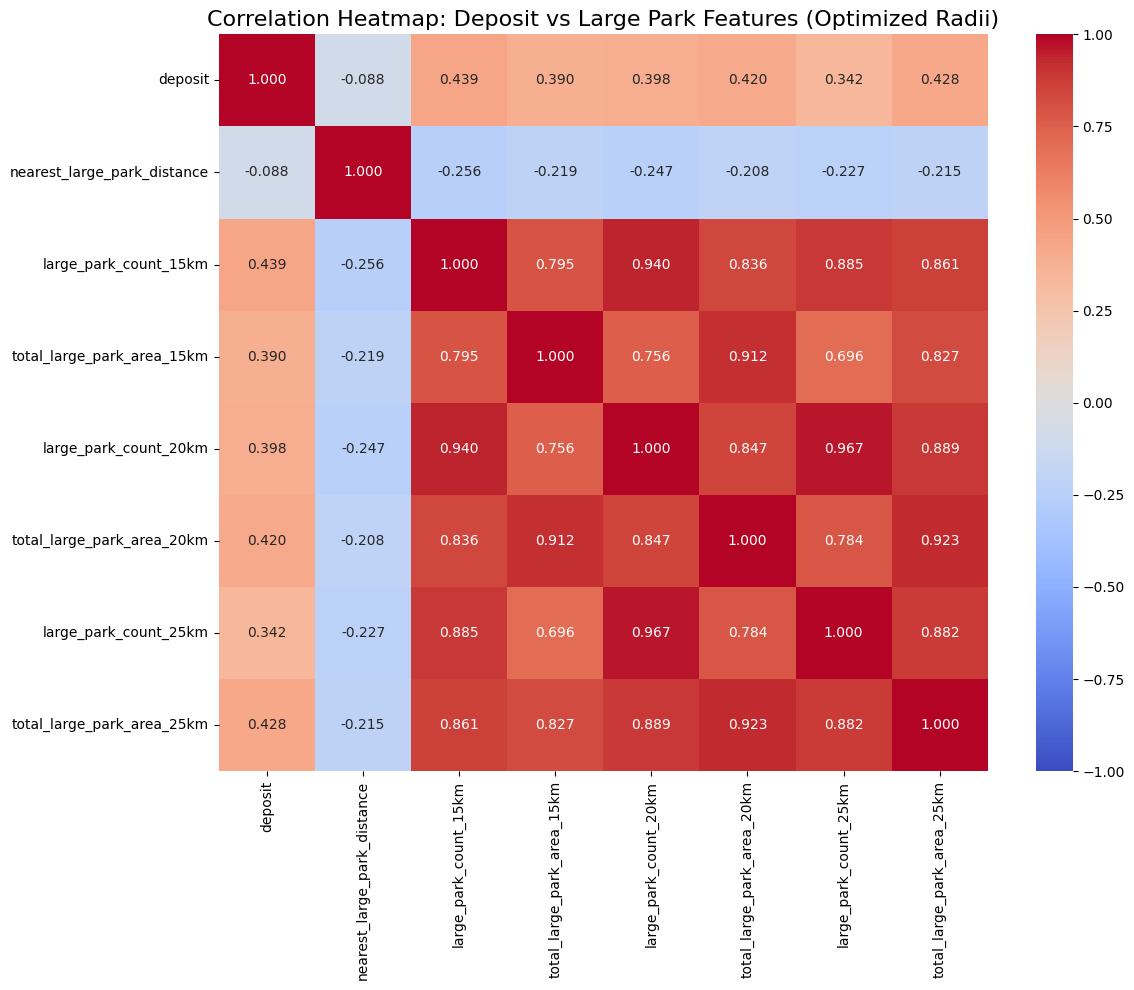

Correlation with deposit:
deposit                        1.000000
large_park_count_15km          0.439444
total_large_park_area_25km     0.428184
total_large_park_area_20km     0.419726
large_park_count_20km          0.398037
total_large_park_area_15km     0.390086
large_park_count_25km          0.342226
nearest_large_park_distance   -0.087506
Name: deposit, dtype: float64


In [41]:
def create_large_park_features(train_df, park_df, size_threshold=100000, radii=[15, 20, 25]):
    # 대형 공원만 필터링
    large_parks = park_df[park_df['area'] >= size_threshold].reset_index(drop=True)
    
    # BallTree 생성
    large_park_coords = large_parks[['latitude', 'longitude']].values
    large_park_tree = BallTree(np.deg2rad(large_park_coords), metric='haversine')
    
    # 아파트 좌표
    apartment_coords = train_df[['latitude', 'longitude']].values
    
    # 새로운 특성 생성
    features = pd.DataFrame(index=train_df.index)
    
    # 가장 가까운 대형 공원까지의 거리
    distances, _ = large_park_tree.query(np.deg2rad(apartment_coords), k=1)
    features['nearest_large_park_distance'] = distances.ravel() * 6371  # km로 변환
    
    # 각 반경 내 대형 공원의 수와 총 면적
    for radius in radii:
        indices = large_park_tree.query_radius(np.deg2rad(apartment_coords), r=radius/6371)
        
        # 공원 수
        features[f'large_park_count_{radius}km'] = [len(idx) for idx in indices]
        
        # 총 면적
        total_areas = [large_parks.loc[idx, 'area'].sum() if len(idx) > 0 else 0 for idx in indices]
        features[f'total_large_park_area_{radius}km'] = total_areas
    
    return pd.concat([train_df, features], axis=1)

# 대형 공원 특성 생성
train_with_large_park_features = create_large_park_features(train_sample, park)

# 상관관계 계산
columns_of_interest = ['deposit'] + [col for col in train_with_large_park_features.columns if 'large_park' in col]
correlation_data = train_with_large_park_features[columns_of_interest]
correlation_matrix = correlation_data.corr()

# 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.3f')
plt.title("Correlation Heatmap: Deposit vs Large Park Features (Optimized Radii)", fontsize=16)
plt.tight_layout()
plt.show()

# 상관계수 출력
print("Correlation with deposit:")
print(correlation_matrix['deposit'].sort_values(ascending=False))

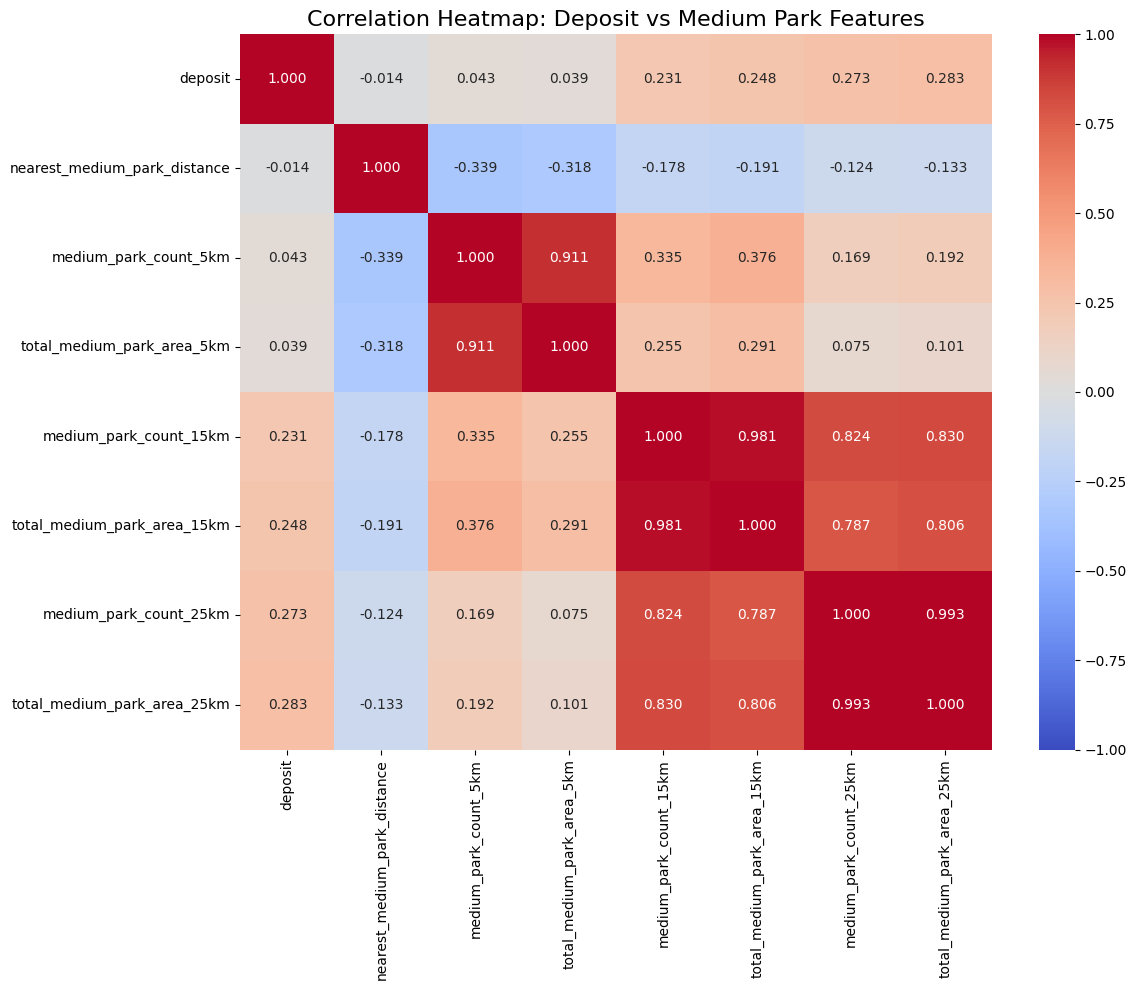

Correlation with deposit:
deposit                         1.000000
total_medium_park_area_25km     0.283164
medium_park_count_25km          0.272990
total_medium_park_area_15km     0.248218
medium_park_count_15km          0.231266
medium_park_count_5km           0.042758
total_medium_park_area_5km      0.038626
nearest_medium_park_distance   -0.014457
Name: deposit, dtype: float64


In [42]:
def create_medium_park_features(train_df, park_df, min_size=10000, max_size=100000, radii=[5, 15, 25]):
    # 중공원만 필터링
    medium_parks = park_df[(park_df['area'] >= min_size) & (park_df['area'] < max_size)].reset_index(drop=True)
    
    # BallTree 생성
    medium_park_coords = medium_parks[['latitude', 'longitude']].values
    medium_park_tree = BallTree(np.deg2rad(medium_park_coords), metric='haversine')
    
    # 아파트 좌표
    apartment_coords = train_df[['latitude', 'longitude']].values
    
    # 새로운 특성 생성
    features = pd.DataFrame(index=train_df.index)
    
    # 가장 가까운 중공원까지의 거리
    distances, _ = medium_park_tree.query(np.deg2rad(apartment_coords), k=1)
    features['nearest_medium_park_distance'] = distances.ravel() * 6371  # km로 변환
    
    # 각 반경 내 중공원의 수와 총 면적
    for radius in radii:
        indices = medium_park_tree.query_radius(np.deg2rad(apartment_coords), r=radius/6371)
        
        # 공원 수
        features[f'medium_park_count_{radius}km'] = [len(idx) for idx in indices]
        
        # 총 면적
        total_areas = [medium_parks.loc[idx, 'area'].sum() if len(idx) > 0 else 0 for idx in indices]
        features[f'total_medium_park_area_{radius}km'] = total_areas
    
    return pd.concat([train_df, features], axis=1)

# 중공원 특성 생성
train_with_medium_park_features = create_medium_park_features(train_sample, park)

# 상관관계 계산
columns_of_interest = ['deposit'] + [col for col in train_with_medium_park_features.columns if 'medium_park' in col]
correlation_data = train_with_medium_park_features[columns_of_interest]
correlation_matrix = correlation_data.corr()

# 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.3f')
plt.title("Correlation Heatmap: Deposit vs Medium Park Features", fontsize=16)
plt.tight_layout()
plt.show()

# 상관계수 출력
print("Correlation with deposit:")
print(correlation_matrix['deposit'].sort_values(ascending=False))

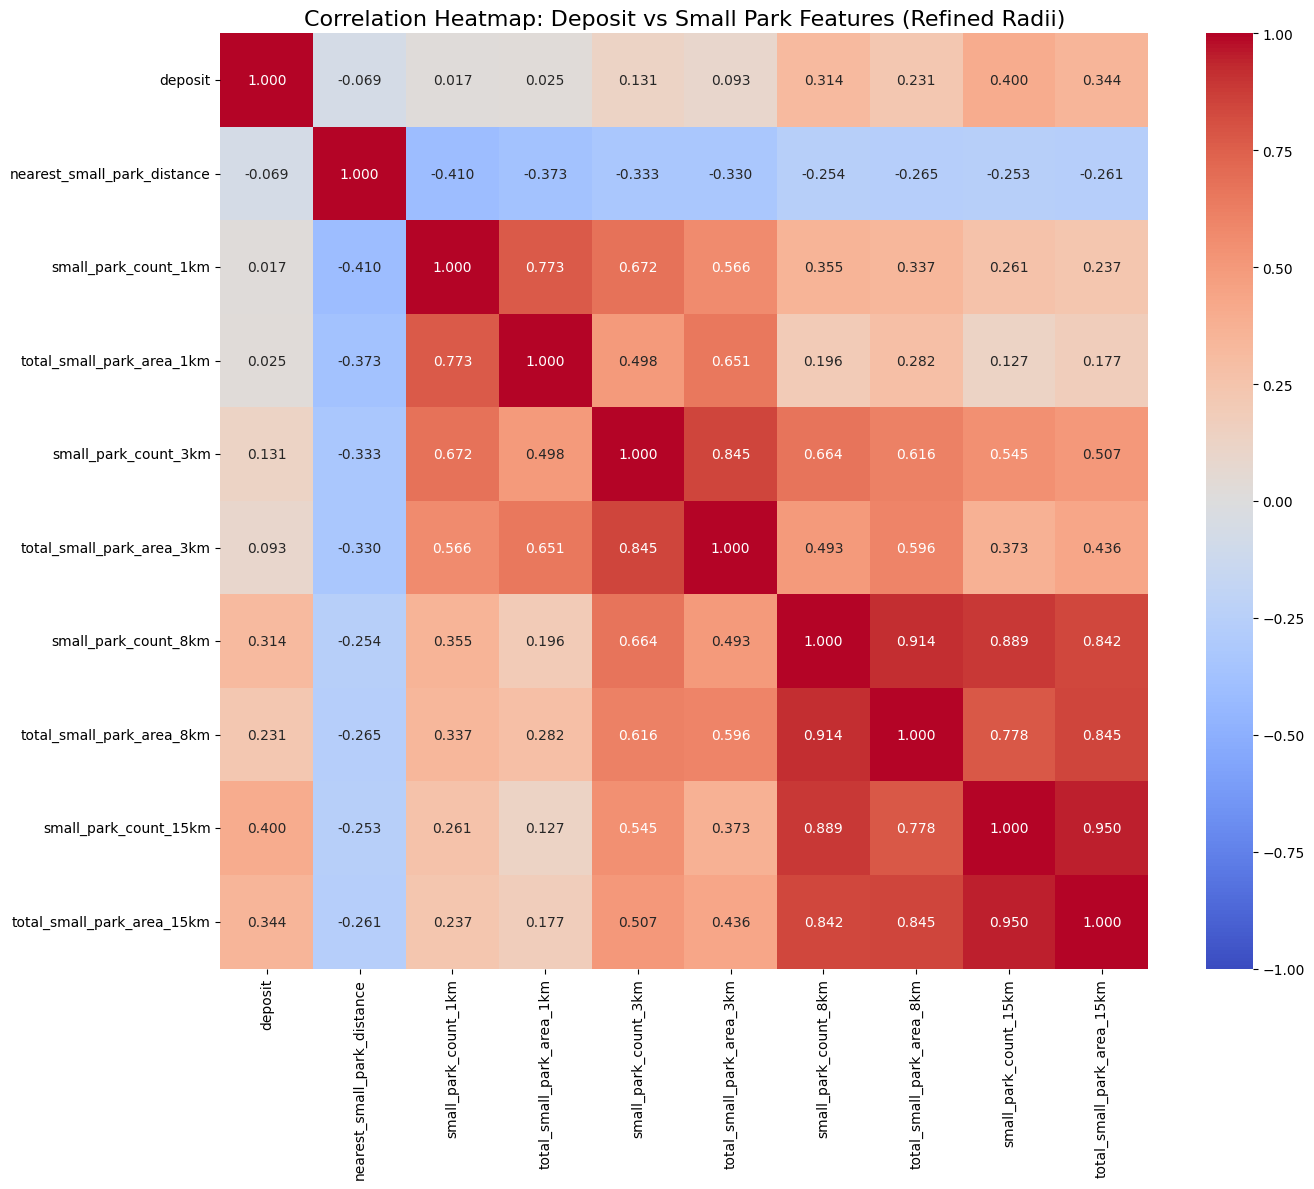

Correlation with deposit:
deposit                        1.000000
small_park_count_15km          0.399767
total_small_park_area_15km     0.344148
small_park_count_8km           0.314068
total_small_park_area_8km      0.230711
small_park_count_3km           0.131055
total_small_park_area_3km      0.092908
total_small_park_area_1km      0.024744
small_park_count_1km           0.017348
nearest_small_park_distance   -0.069035
Name: deposit, dtype: float64


In [43]:
def create_small_park_features(train_df, park_df, max_size=10000, radii=[1, 3, 8, 15]):
    # 소공원만 필터링
    small_parks = park_df[park_df['area'] < max_size].reset_index(drop=True)
    
    # BallTree 생성
    small_park_coords = small_parks[['latitude', 'longitude']].values
    small_park_tree = BallTree(np.deg2rad(small_park_coords), metric='haversine')
    
    # 아파트 좌표
    apartment_coords = train_df[['latitude', 'longitude']].values
    
    # 새로운 특성 생성
    features = pd.DataFrame(index=train_df.index)
    
    # 가장 가까운 소공원까지의 거리
    distances, _ = small_park_tree.query(np.deg2rad(apartment_coords), k=1)
    features['nearest_small_park_distance'] = distances.ravel() * 6371  # km로 변환
    
    # 각 반경 내 소공원의 수와 총 면적
    for radius in radii:
        indices = small_park_tree.query_radius(np.deg2rad(apartment_coords), r=radius/6371)
        
        # 공원 수
        features[f'small_park_count_{radius}km'] = [len(idx) for idx in indices]
        
        # 총 면적
        total_areas = [small_parks.loc[idx, 'area'].sum() if len(idx) > 0 else 0 for idx in indices]
        features[f'total_small_park_area_{radius}km'] = total_areas
    
    return pd.concat([train_df, features], axis=1)

# 소공원 특성 생성
train_with_small_park_features = create_small_park_features(train_sample, park)

# 상관관계 계산
columns_of_interest = ['deposit'] + [col for col in train_with_small_park_features.columns if 'small_park' in col]
correlation_data = train_with_small_park_features[columns_of_interest]
correlation_matrix = correlation_data.corr()

# 히트맵 생성
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.3f')
plt.title("Correlation Heatmap: Deposit vs Small Park Features (Refined Radii)", fontsize=16)
plt.tight_layout()
plt.show()

# 상관계수 출력
print("Correlation with deposit:")
print(correlation_matrix['deposit'].sort_values(ascending=False))

대공원의 상관관계가 가장 커서 feature로 사용

# 학교 데이터 파악

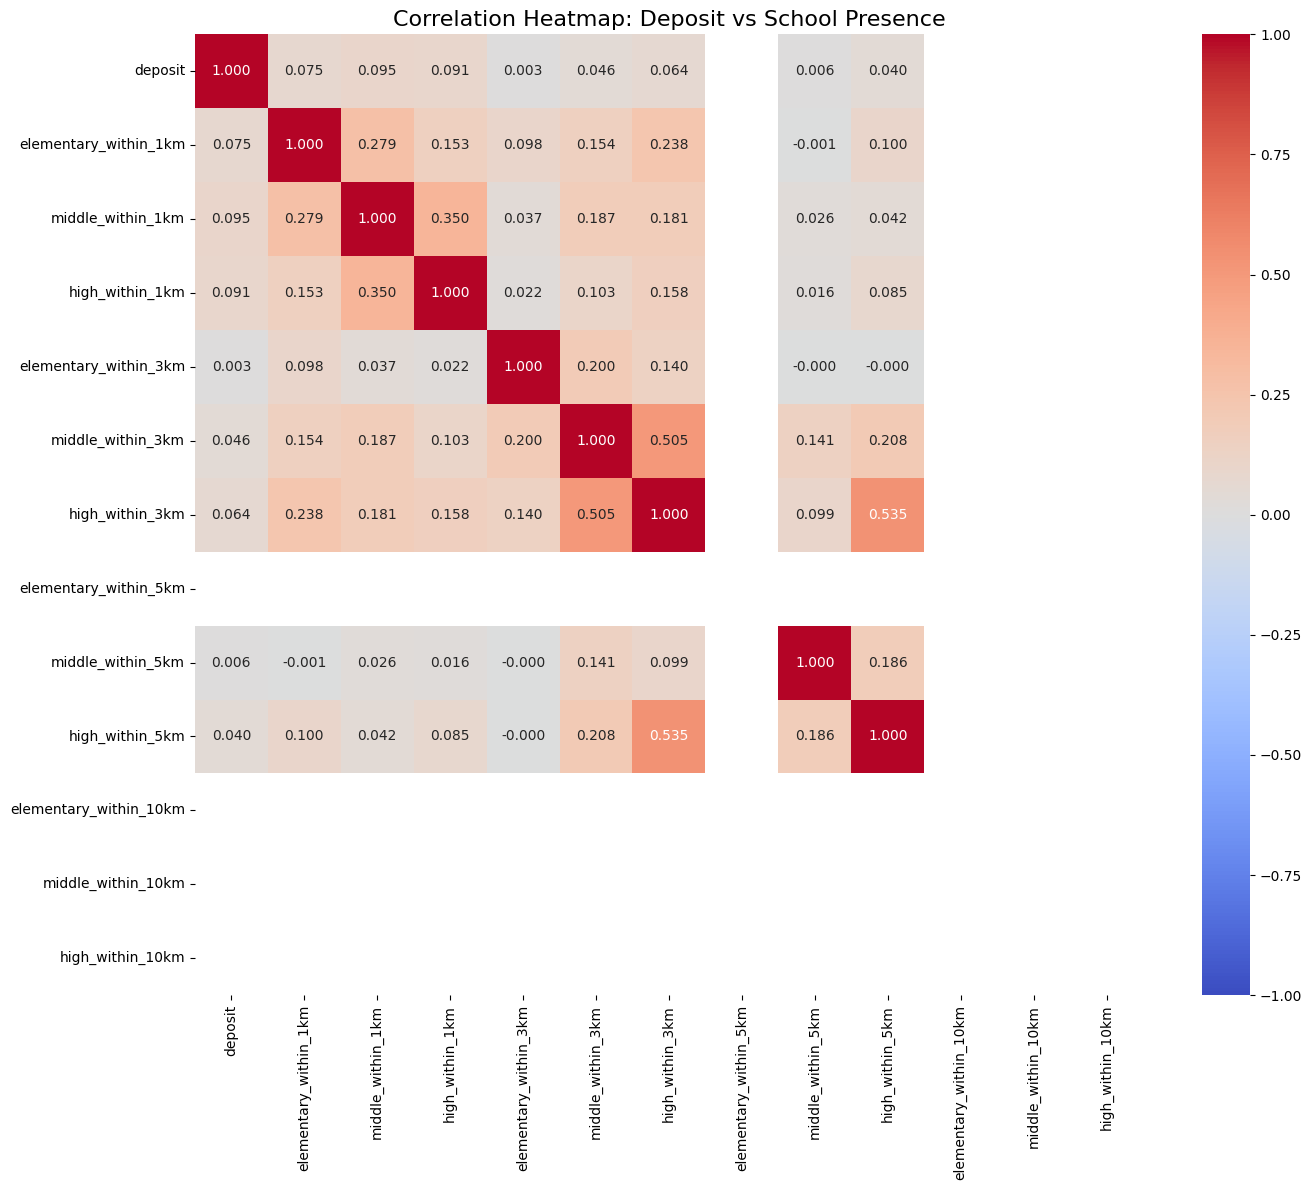

Correlation with deposit:
deposit                   1.000000
middle_within_1km         0.094709
high_within_1km           0.091326
elementary_within_1km     0.075083
high_within_3km           0.063563
middle_within_3km         0.046470
high_within_5km           0.040199
middle_within_5km         0.006408
elementary_within_3km     0.003054
elementary_within_5km          NaN
elementary_within_10km         NaN
middle_within_10km             NaN
high_within_10km               NaN
Name: deposit, dtype: float64


In [46]:
def create_school_presence_features(train_df, school_df, radii=[1, 3, 5, 10]):
    # 학교 유형별로 데이터 분리
    school_types = ['elementary', 'middle', 'high']
    school_trees = {}
    
    for school_type in school_types:
        type_schools = school_df[school_df['schoolLevel'] == school_type]
        school_coords = type_schools[['latitude', 'longitude']].values
        school_trees[school_type] = BallTree(np.deg2rad(school_coords), metric='haversine')
    
    # 아파트 좌표
    apartment_coords = train_df[['latitude', 'longitude']].values
    
    # 새로운 특성 생성
    features = pd.DataFrame(index=train_df.index)
    
    for radius in radii:
        for school_type in school_types:
            # 해당 반경 내 학교 존재 여부 확인 (1: 존재, 0: 없음)
            presence = school_trees[school_type].query_radius(np.deg2rad(apartment_coords), r=radius/6371, count_only=True) > 0
            features[f'{school_type}_within_{radius}km'] = presence.astype(int)
    
    return pd.concat([train_df, features], axis=1)

# 학교 특성 생성
train_with_school_features = create_school_presence_features(train_sample, schools)

# 상관관계 계산
school_columns = [col for col in train_with_school_features.columns if 'within' in col]
columns_of_interest = ['deposit'] + school_columns
correlation_data = train_with_school_features[columns_of_interest]
correlation_matrix = correlation_data.corr()

# 히트맵 생성
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.3f')
plt.title("Correlation Heatmap: Deposit vs School Presence", fontsize=16)
plt.tight_layout()
plt.show()

# 상관계수 출력
print("Correlation with deposit:")
print(correlation_matrix['deposit'].sort_values(ascending=False))

- elementary_within_5km NaN
- elementary_within_10km NaN
- middle_within_10km NaN
- high_within_10km NaN

모든 전셋집의 10km반경내에 학교가 있음을 시사

전셋집 10,15,20km 반경 초,중,고등 학교 갯수로 상관관계 파악

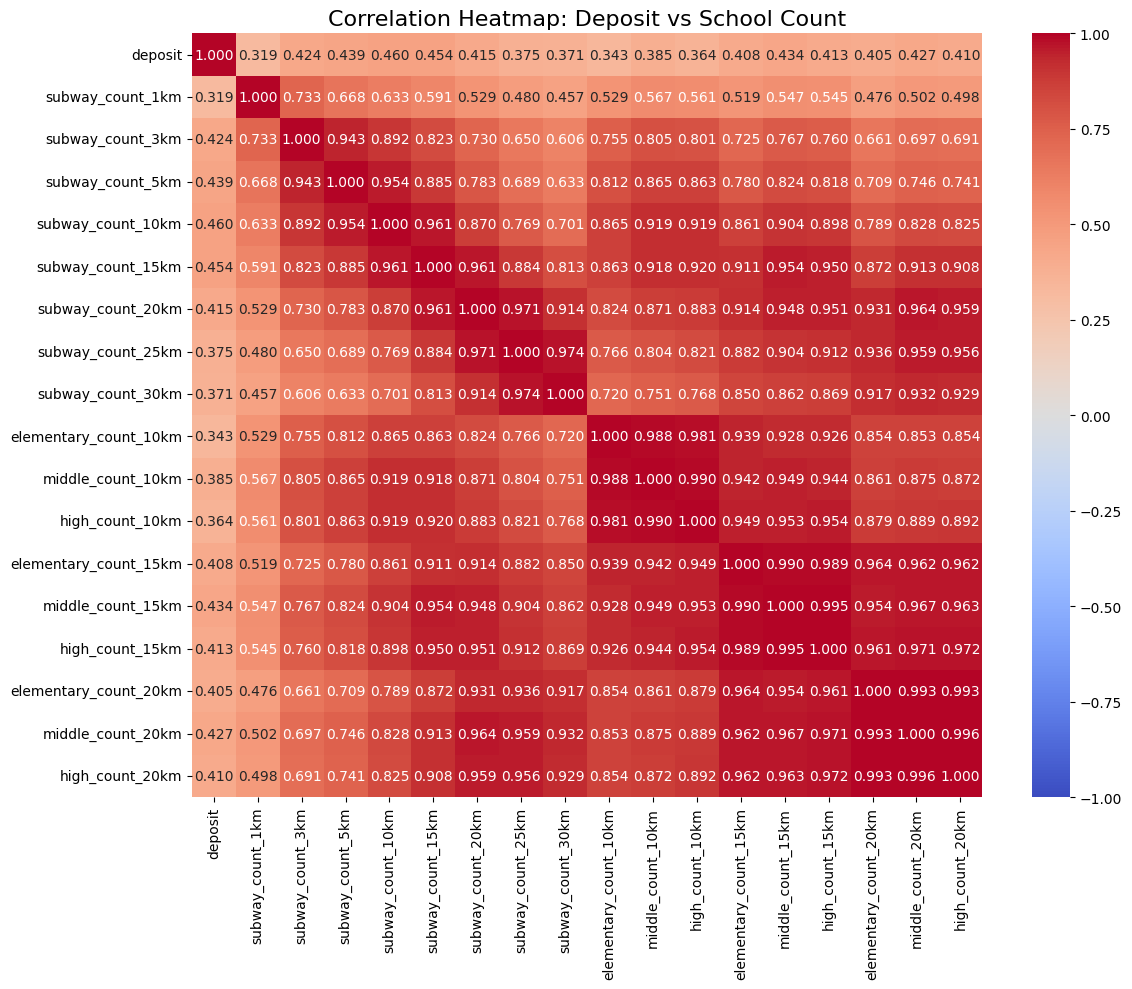

Correlation with deposit:
deposit                  1.000000
subway_count_10km        0.459576
subway_count_15km        0.454123
subway_count_5km         0.439063
middle_count_15km        0.434425
middle_count_20km        0.426808
subway_count_3km         0.424270
subway_count_20km        0.414890
high_count_15km          0.413312
high_count_20km          0.410354
elementary_count_15km    0.408396
elementary_count_20km    0.404808
middle_count_10km        0.384792
subway_count_25km        0.375349
subway_count_30km        0.371112
high_count_10km          0.363597
elementary_count_10km    0.343277
subway_count_1km         0.319048
Name: deposit, dtype: float64


In [48]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import seaborn as sns
import matplotlib.pyplot as plt

def create_school_count_features(train_df, school_df, radii=[10, 15, 20]):
    school_types = ['elementary', 'middle', 'high']
    school_trees = {}
    
    for school_type in school_types:
        type_schools = school_df[school_df['schoolLevel'] == school_type]
        school_coords = type_schools[['latitude', 'longitude']].values
        school_trees[school_type] = BallTree(np.deg2rad(school_coords), metric='haversine')
    
    apartment_coords = train_df[['latitude', 'longitude']].values
    
    features = pd.DataFrame(index=train_df.index)
    
    for radius in radii:
        for school_type in school_types:
            count = school_trees[school_type].query_radius(np.deg2rad(apartment_coords), r=radius/6371, count_only=True)
            features[f'{school_type}_count_{radius}km'] = count
    
    return pd.concat([train_df, features], axis=1)

# 학교 개수 특성 생성
train_with_school_counts = create_school_count_features(train_sample, schools)

# 상관관계 계산
school_columns = [col for col in train_with_school_counts.columns if '_count_' in col]
columns_of_interest = ['deposit'] + school_columns
correlation_data = train_with_school_counts[columns_of_interest]
correlation_matrix = correlation_data.corr()

# 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.3f')
plt.title("Correlation Heatmap: Deposit vs School Count", fontsize=16)
plt.tight_layout()
plt.show()

# 상관계수 출력
print("Correlation with deposit:")
print(correlation_matrix['deposit'].sort_values(ascending=False))

# 금리 데이터 파악

In [37]:
interest['year_month_date'] = pd.to_datetime(interest['year_month'], format='%Y%m')
interest

year_month  interest_rate year_month_date
0      202405           3.56      2024-05-01
1      202404           3.54      2024-04-01
2      202403           3.59      2024-03-01
3      202402           3.62      2024-02-01
4      202401           3.66      2024-01-01
..        ...            ...             ...
61     201904           1.85      2019-04-01
62     201903           1.94      2019-03-01
63     201902           1.92      2019-02-01
64     201901           1.99      2019-01-01
65     201812           2.04      2018-12-01

[66 rows x 3 columns]

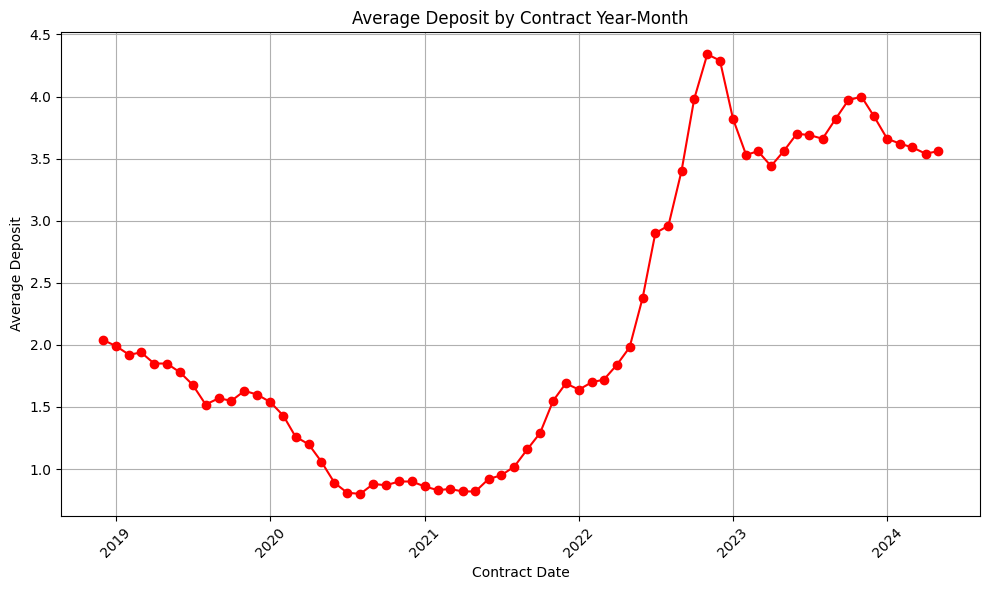

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(interest['year_month_date'], interest['interest_rate'], marker='o', linestyle='-', color='red')
plt.xticks(rotation=45)  
plt.title('Average Deposit by Contract Year-Month')
plt.xlabel('Contract Date')
plt.ylabel('Average Deposit')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_843423/1549346169.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(avg_deposit_by_month.index, rotation=45)


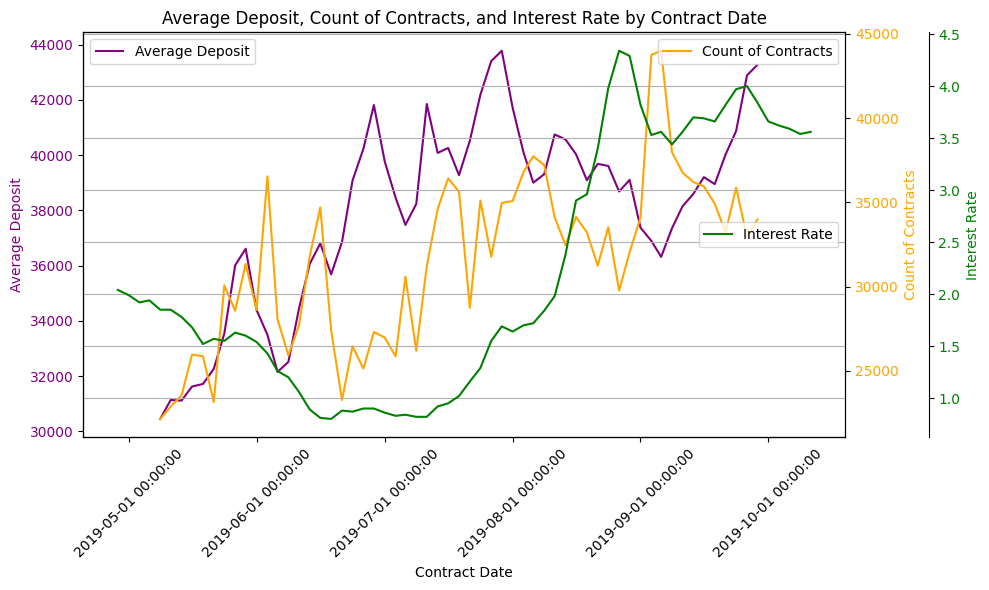

In [43]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 Y축: deposit 평균
ax1.plot(avg_deposit_by_month.index, avg_deposit_by_month.values, linestyle='-', color='purple', label='Average Deposit')
ax1.set_xlabel('Contract Date')
ax1.set_ylabel('Average Deposit', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')
ax1.set_xticklabels(avg_deposit_by_month.index, rotation=45)

# 두 번째 Y축: contract_date 개수
ax2 = ax1.twinx() 
ax2.plot(count_contracts_by_month.index, count_contracts_by_month.values, linestyle='-', color='orange', label='Count of Contracts')
ax2.set_ylabel('Count of Contracts', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 세 번째 Y축: interest_rate
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # 세 번째 축을 오른쪽으로 60포인트 밀기
ax3.plot(interest['year_month_date'], interest['interest_rate'], linestyle='-', color='green', label='Interest Rate')
ax3.set_ylabel('Interest Rate', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# 제목 및 범례
plt.title('Average Deposit, Count of Contracts, and Interest Rate by Contract Date')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='center right')

# 겹치는 그래프들 간의 간격 조정
plt.grid(True)
plt.tight_layout()

plt.show()